# 소개:
- 이 노트북에서는 NASA에서 얻은 배터리 충전/방전 데이터 세트에 대해 여러 가지 기법을 사용하여 **전처리, 분석, 감지 및 여러 이상값/이상치**를 처리했습니다.
- 다음과 같이 가장 널리 사용되는 5가지 이상/이상값 탐지 기법을 사용했습니다:
    - IQR 기반
    - DBSCAN(밀도 기반)
    - Isolation Forest
    - Local Outlier Factor (LOF)
    - Elliptical Envelope

# 문제 진술:
- NASA는 우주용 수소 연료전지 전기 자동차(FCEV)를 만드는 실험을 하고 있습니다. 수소 연료전지 전기차는 온보드 수소를 사용하여 전력을 생산하는 수소 연료전지로 구동됩니다. 이 수소전기차는 수소를 가득 채우면 최대 600킬로미터까지 갈 수 있습니다.
- 그들은 수소 연료 전지 센서와 관련된 몇 가지 매개 변수를 이해하는 데 도움을 받기 위해 NASA의 **데이터 과학 팀**에 연락을 취했습니다. NASA의 R&D 팀에서 일하는 데이터 과학자는 **셀의 노화 과정, 충전 및 방전 주기를 분석하고 데이터에서 보이는 몇 가지 이상 징후/사례를 분리해야 합니다**.

## 데이터 사전:
- 전압_측정: 연료 전지 단자 전압(볼트)
- 전류_측정: 연료 전지 출력 전류(암페어)
- 온도_측정: 연료 전지 온도(°C)
- 전류_부하: 부하에서 측정된 전류(암페어)
- 전압_부하: 부하에서 측정된 전압(볼트)
- 시간: 사이클의 시간 벡터(초)
- 용량: 용량: 2.7V까지 방전할 수 있는 연료 전지 용량(Ahr)
- 날짜: 사이클 시작 날짜 및 시간
- 주변_온도: 연료 전지가 저장되는 온도(섭씨)
- 사이클: 연료 전지의 충전 주기

## 데이터 설명:
- 4개의 연료 전지 세트(# 5, 6, 7, 18)를 상온에서 2가지 작동 프로파일(충전 및 방전)로 실행했습니다. 충전은 연료 전지 전압이 4.2V에 도달할 때까지 1.5A의 정전류(CC) 모드에서 수행한 다음 충전 전류가 20mA로 떨어질 때까지 정전압(CV) 모드에서 계속 수행했습니다. 방전은 연료 전지 5 6 7 및 18에 대해 배터리 전압이 각각 2.7V, 2.5V, 2.2V 및 2.5V로 떨어질 때까지 2A의 정전류(CC) 수준에서 수행되었습니다.
- 충전 및 방전 사이클이 반복되면 연료 전지의 노화가 가속화됩니다. 연료 전지가 정격 용량이 30% 감소(2Ahr에서 1.4Ahr로)하는 수명 종료(EOL) 기준에 도달했을 때 실험을 중단했습니다.

- 이 데이터는 (주어진 방전 주기에 대한) 잔여 충전량과 남은 유효 수명(RUL)을 예측하는 데 추가로 사용할 수 있습니다.

 - 파일:

    - B0005.mat Data for Fuel cell #5

    - B0006.mat Data for Fuel cell #6

    - B0007.mat Data for Fuel cell #7

    - B0018.mat Data for Fuel cell #18


### 라이브러리 불러오기

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Matlab 파일들 csv파일로 변환:

In [2]:
def load_data(nm,battery): # Example of input load_data('B0006.mat','B0006')
    mat = loadmat(nm)
    print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
    counter = 0
    dataset = []
    capacity_data = []
    
    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge':
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                                          int(row['time'][0][1]),
                                          int(row['time'][0][2]),
                                          int(row['time'][0][3]),
                                          int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                voltage_measured, current_measured,
                                temperature_measured, current_load,
                                voltage_load, time])
            capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
            counter = counter + 1
    print(dataset[0])
    return [pd.DataFrame(data=dataset,
                         columns=['cycle', 'ambient_temperature', 'datetime',
                                  'capacity', 'voltage_measured',
                                  'current_measured', 'temperature_measured',
                                  'current_load', 'voltage_load', 'time']),
            pd.DataFrame(data=capacity_data,
                         columns=['cycle', 'ambient_temperature', 'datetime',
                                  'capacity'])]

In [3]:
B0005_dataset, B0005_capacity = load_data('./data/nasa_mat/B0005.mat','B0005')
B0005_dataset['flag'] = 1

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


In [4]:
B0006_dataset, B0006_capacity = load_data('./data/nasa_mat/B0006.mat','B0006')
B0006_dataset['flag'] = 2

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]


In [5]:
B0007_dataset, B0007_capacity = load_data('./data/nasa_mat/B0007.mat','B0007')
B0007_dataset['flag'] = 3

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0.0004, 0.0, 0.0]


In [6]:
B0018_dataset, B0018_capacity = load_data('./data/nasa_mat/B0018.mat','B0018')
B0018_dataset['flag'] = 4

Total data in dataset:  319
[1, 24, datetime.datetime(2008, 7, 7, 15, 15, 28), 1.8550045207910817, 4.188108651124536, 0.00013066734156636677, 23.8195202516044, 0.0006, 0.0, 0.0]


In [7]:
fuel_cells_df = pd.concat([B0005_dataset,B0006_dataset,B0007_dataset,B0018_dataset], ignore_index = True)

In [8]:
# csv 파일 저장
# fuel_cells_df.to_csv('B0005_6_7_18.csv', index=False)

In [9]:
fuel_cells_df

cycle  ambient_temperature            datetime  capacity  \
0           1                   24 2008-04-02 15:25:41  1.856487   
1           1                   24 2008-04-02 15:25:41  1.856487   
2           1                   24 2008-04-02 15:25:41  1.856487   
3           1                   24 2008-04-02 15:25:41  1.856487   
4           1                   24 2008-04-02 15:25:41  1.856487   
...       ...                  ...                 ...       ...   
185716    132                   24 2008-08-20 08:37:19  1.341051   
185717    132                   24 2008-08-20 08:37:19  1.341051   
185718    132                   24 2008-08-20 08:37:19  1.341051   
185719    132                   24 2008-08-20 08:37:19  1.341051   
185720    132                   24 2008-08-20 08:37:19  1.341051   

        voltage_measured  current_measured  temperature_measured  \
0               4.191492         -0.004902             24.330034   
1               4.190749         -0.001478             24.325993   
2               3.974871         -2.012528             24.389085   
3               3.951717         -2.013979             24.544752   
4               3.934352         -2.011144             24.731385   
...                  ...               ...                   ...   
185716          3.443760         -0.002426             35.383979   
185717          3.453271         -0.000981             35.179732   
185718          3.461963          0.000209             34.977000   
185719          3.469907          0.001516             34.785943   
185720          3.477277         -0.001940             34.581660   

        current_load  voltage_load      time  flag  
0            -0.0006         0.000     0.000     1  
1            -0.0006         4.206    16.781     1  
2            -1.9982         3.062    35.703     1  
3            -1.9982         3.030    53.781     1  
4            -1.9982         3.011    71.922     1  
...              ...           ...       ...   ...  
185716        0.0006         0.000  2686.359     4  
185717        0.0006         0.000  2700.546     4  
185718        0.0006         0.000  2714.640     4  
185719        0.0006         0.000  2728.750     4  
185720        0.0006         0.000  2742.843     4  

[185721 rows x 11 columns]

### 변수 및 데이터 유형 식별:

In [10]:
fuel_cells_df.shape

(185721, 11)

In [11]:
fuel_cells_df.columns

Index(['cycle', 'ambient_temperature', 'datetime', 'capacity',
       'voltage_measured', 'current_measured', 'temperature_measured',
       'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

In [12]:
fuel_cells_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185721 entries, 0 to 185720
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   cycle                 185721 non-null  int64         
 1   ambient_temperature   185721 non-null  uint8         
 2   datetime              185721 non-null  datetime64[ns]
 3   capacity              185721 non-null  float64       
 4   voltage_measured      185721 non-null  float64       
 5   current_measured      185721 non-null  float64       
 6   temperature_measured  185721 non-null  float64       
 7   current_load          185721 non-null  float64       
 8   voltage_load          185721 non-null  float64       
 9   time                  185721 non-null  float64       
 10  flag                  185721 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), uint8(1)
memory usage: 14.3 MB


### 고유값 확인:

In [13]:
for i in fuel_cells_df.columns:
    print(i, ":" , fuel_cells_df[i].nunique())
       

cycle : 168
ambient_temperature : 1
datetime : 300
capacity : 636
voltage_measured : 185721
current_measured : 185721
temperature_measured : 185721
current_load : 21
voltage_load : 1835
time : 62016
flag : 4


In [14]:
fuel_cells_df.drop('ambient_temperature', axis = 1, inplace = True)

In [15]:
fuel_cells_df

cycle            datetime  capacity  voltage_measured  \
0           1 2008-04-02 15:25:41  1.856487          4.191492   
1           1 2008-04-02 15:25:41  1.856487          4.190749   
2           1 2008-04-02 15:25:41  1.856487          3.974871   
3           1 2008-04-02 15:25:41  1.856487          3.951717   
4           1 2008-04-02 15:25:41  1.856487          3.934352   
...       ...                 ...       ...               ...   
185716    132 2008-08-20 08:37:19  1.341051          3.443760   
185717    132 2008-08-20 08:37:19  1.341051          3.453271   
185718    132 2008-08-20 08:37:19  1.341051          3.461963   
185719    132 2008-08-20 08:37:19  1.341051          3.469907   
185720    132 2008-08-20 08:37:19  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  
0          0.000     1  
1         16.781     1  
2         35.703     1  
3         53.781     1  
4         71.922     1  
...          ...   ...  
185716  2686.359     4  
185717  2700.546     4  
185718  2714.640     4  
185719  2728.750     4  
185720  2742.843     4  

[185721 rows x 10 columns]

In [16]:
fuel_cells_df.describe(include=[np.number]).transpose()

count         mean         std        min  \
cycle                 185721.0    82.838758   45.692247   1.000000   
capacity              185721.0     1.574863    0.190633   1.153818   
voltage_measured      185721.0     3.497219    0.251691   1.737030   
current_measured      185721.0    -1.832569    0.561405  -2.029098   
temperature_measured  185721.0    32.378997    4.027737  22.350256   
current_load          185721.0     1.465434    1.226874  -2.000000   
voltage_load          185721.0     2.366494    0.751377   0.000000   
time                  185721.0  1546.379935  906.958628   0.000000   
flag                  185721.0     2.375466    1.073068   1.000000   

                             25%          50%          75%          max  
cycle                  45.000000    81.000000   120.000000   168.000000  
capacity                1.426025     1.559634     1.741850     2.035338  
voltage_measured        3.377653     3.500859     3.655751     4.233325  
current_measured       -2.011418    -2.009015    -1.989974     0.014306  
temperature_measured   29.570621    32.355737    35.420677    42.332522  
current_load            1.998200     1.998800     1.999000     2.000000  
voltage_load            2.410000     2.558000     2.718000     4.249000  
time                  764.797000  1537.031000  2307.485000  3690.234000  
flag                    1.000000     2.000000     3.000000     4.000000

In [17]:
# Missing values:

def missingValue(df):
    #Identifying Missing data.
    total_null = df.isnull().sum().sort_values(ascending = False)
    percent = ((df.isnull().sum()/len(df))*100).sort_values(ascending = False)
    print(f"Total records in our data =  {df.shape[0]} where missing values are as follows:")

    missing_data = pd.concat([total_null,percent.round(2)],axis=1,keys=['Total Missing','In Percent'])
    return missing_data

In [18]:
missing_df = missingValue(fuel_cells_df)
missing_df[missing_df['Total Missing'] > 0]

Total records in our data =  185721 where missing values are as follows:


Empty DataFrame
Columns: [Total Missing, In Percent]
Index: []

# 단변량 분석:

In [19]:
def numerical_feat(df,colname,nrows=2,mcols=2,width=15,height=70):
    fig , ax = plt.subplots(nrows,mcols,figsize=(width,height))
    fig.set_facecolor("lightgrey")
    rows = 0
    for var in colname:        
        ax[rows][0].set_title("Boxplot for Outlier Detection ", fontweight="bold")
        plt.ylabel(var, fontsize=12)
        sns.boxplot(y = df[var],color='crimson',ax=ax[rows][0])
        
        sns.histplot(df[var],color='purple',ax=ax[rows][1],kde=True)
        ax[rows][1].axvline(df[var].mean(), color='r', linestyle='--', label="Mean")
        ax[rows][1].axvline(df[var].median(), color='m', linestyle='-', label="Median")
        ax[rows][1].axvline(df[var].mode()[0], color='royalblue', linestyle='-', label="Mode")
        ax[rows][1].set_title("Outlier Detection ", fontweight="bold")
        ax[rows][1].legend({'Mean':df[var].mean(),'Median':df[var].median(),'Mode':df[var].mode()})
        rows += 1
    plt.show()

In [20]:
fuel_cells_df.columns

Index(['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

In [21]:
numerical_cols = ['capacity', 'voltage_load']

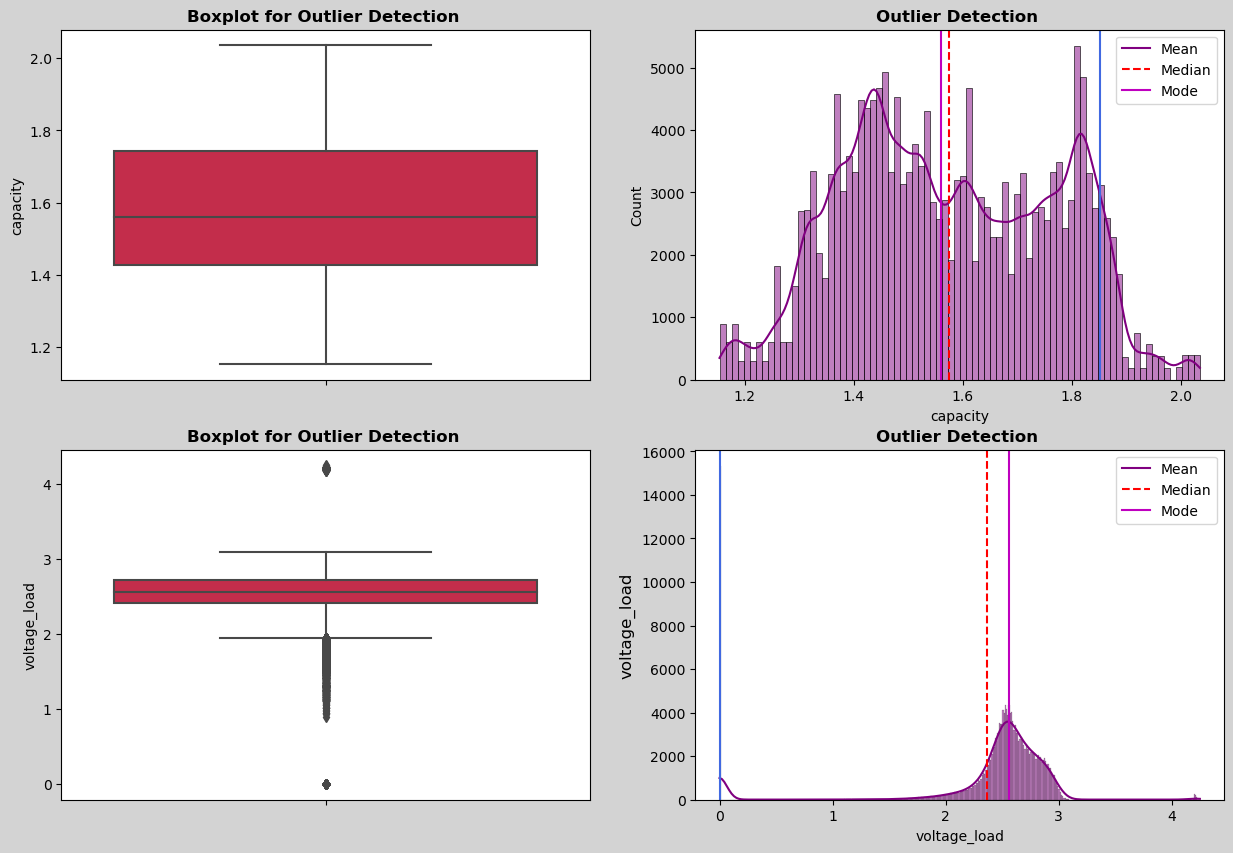

In [22]:
numerical_feat(fuel_cells_df,numerical_cols,len(numerical_cols),2,15,10)

- As we can see, the voltage load gas near normal distribution and has few outliers to the lower end.
- Whereas, capacity is multimodal distributed having almost zero outliers.

In [23]:
categorical_cols = ['flag']

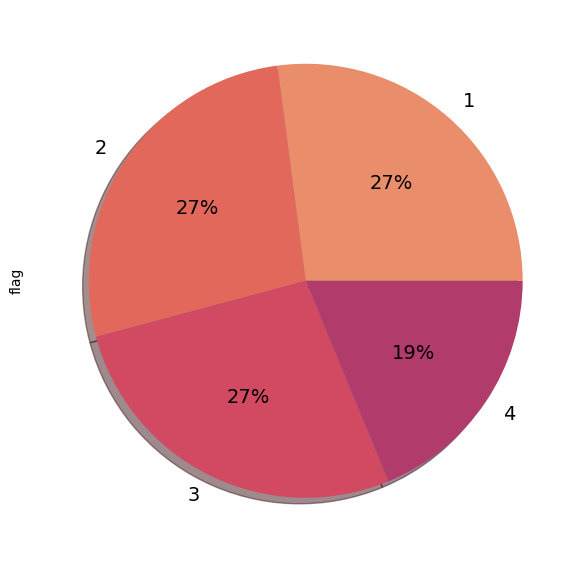

In [24]:
plt.figure(figsize = (7,8))
count = (fuel_cells_df['flag'].value_counts(normalize=True)*100)
count.plot.pie(colors = sns.color_palette("flare"),autopct='%0.0f%%',
                       textprops={'fontsize': 14},shadow = True)
plt.show()

- 배터리 4는 데이터 포인트 수가 가장 적고, 나머지 3개는 데이터 포인트 수가 동일합니다.

# 다변량 분석:

In [25]:
fuel_cells_df.columns

Index(['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

### 1. Capacity w.r.t Cycle

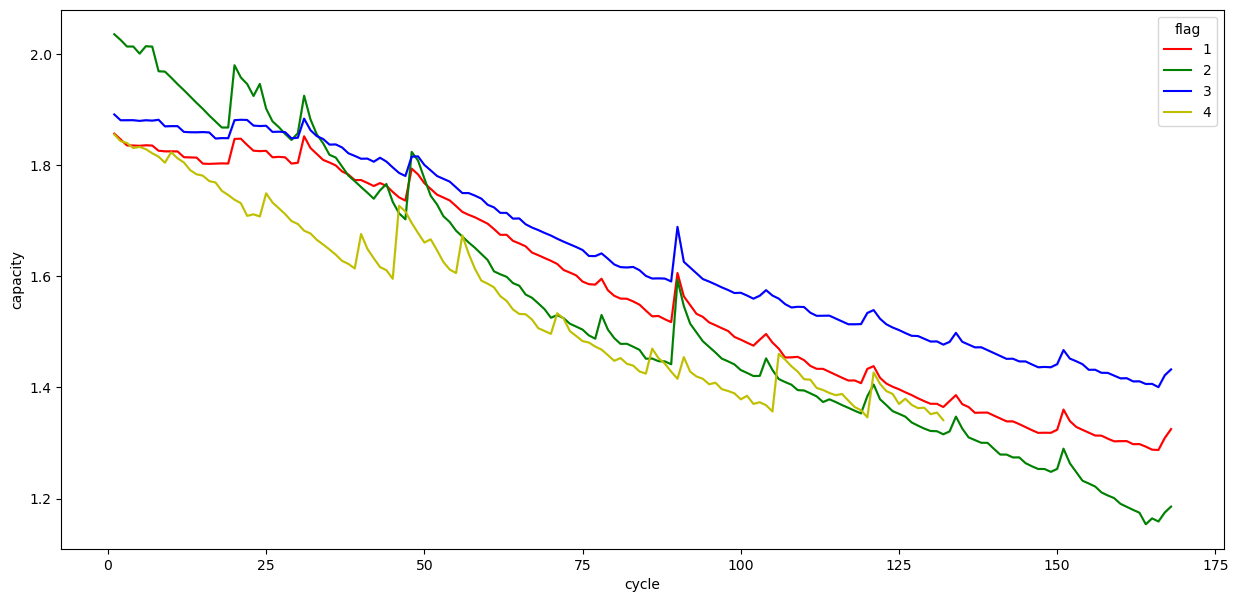

In [26]:
plt.figure(figsize=(15, 7))
sns.lineplot(x = 'cycle', y = 'capacity', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- Batteries:
    - B0005.mat Data for Fuel cell #5
    - B0006.mat Data for Fuel cell #6
    - B0007.mat Data for Fuel cell #7
    - B0018.mat Data for Fuel cell #18


- 사이클이 증가함에 따라 배터리 용량이 감소하는 추세를 보이고 있습니다.
- 배터리 사용 횟수가 증가할수록 배터리 용량이 감소합니다.
- 배터리 B0006은 새 배터리일 때 용량이 가장 큽니다. 반면 B0018과 B0007은 사용하지 않을 때 용량이 가장 적습니다.
- 시간이 지남에 따라 B0006은 다른 배터리보다 훨씬 더 열화되는 경향을 보이는 반면, B0007은 가장 효율적인 용량을 가지고 있습니다.

### 2. Datetime w.r.t time 

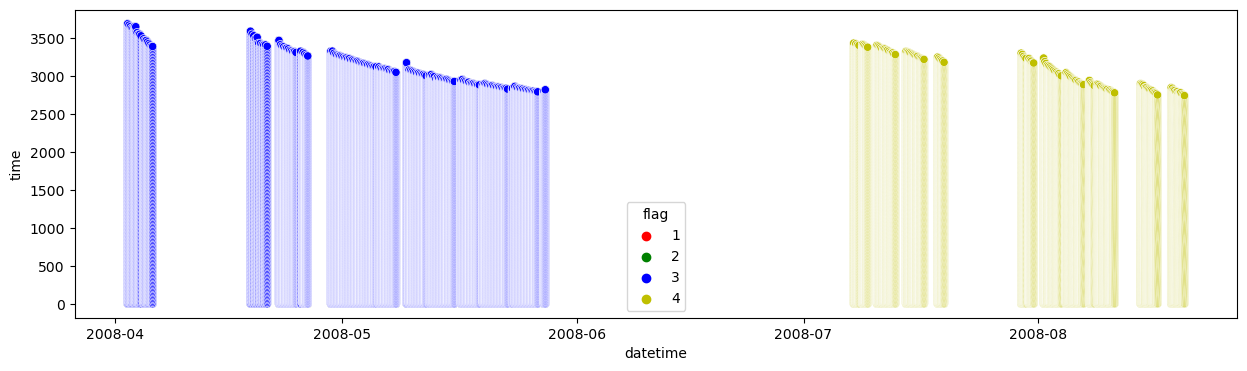

In [27]:
plt.figure(figsize=(15, 4))
sns.scatterplot(x = 'datetime', y = 'time', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- 주기 동안 배터리를 지속적으로 테스트하거나 충전한 적이 없습니다. 
- 처음 세 개의 배터리(5,6,7)는 동시에 충전/테스트된 반면, 네 번째 배터리(B0018)는 2008년 7월 이후에 충전/테스트되었으며 그 사이에 몇 번의 휴식 시간이 있었습니다. 
- 시간이 지남에 따라 배터리 충전 주기가 감소하는 일반적인 추세는 거의 동일합니다.

### 3.Datetime w.r.t capacity

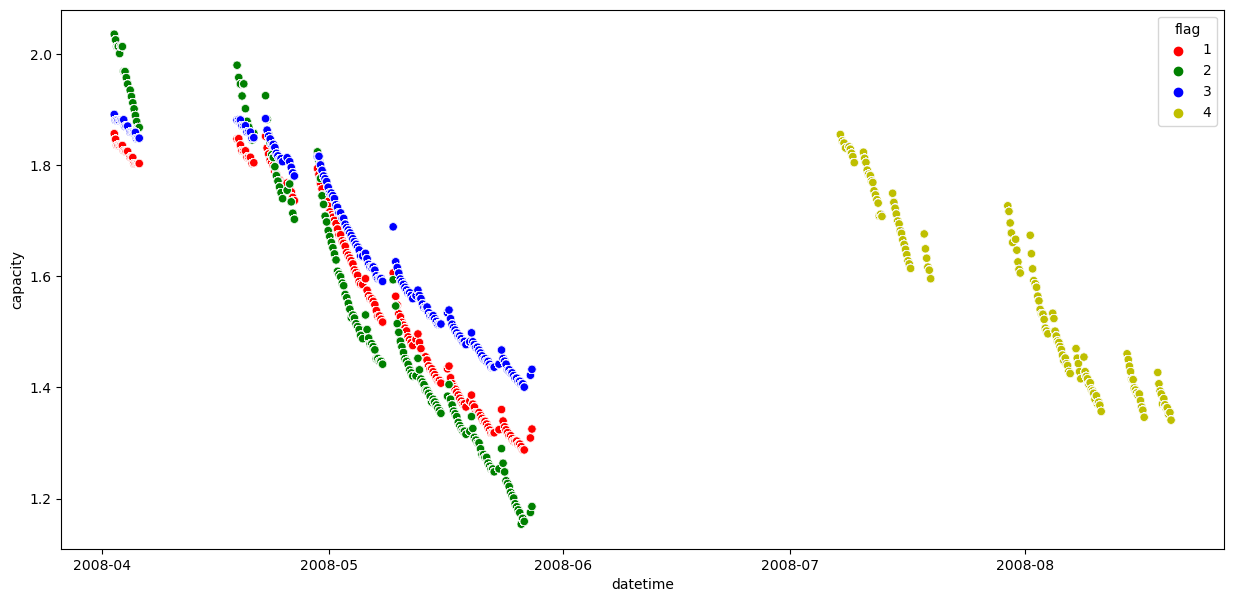

In [28]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x = 'datetime', y = 'capacity', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- 용량은 시간이 지남에 따라 감소합니다.
- 배터리(B0018)는 최근에 출시되어 시간이 지남에 따라 평균 용량을 유지하고 있음을 명확하게 알 수 있습니다.
- 배터리 B0002의 용량은 시간이 지남에 따라 가장 많이 저하되는 반면, 파란색의 경우 일정 기간 동안 용량 측면에서 가장 효율적입니다.

### 4. Capacity w.r.t time

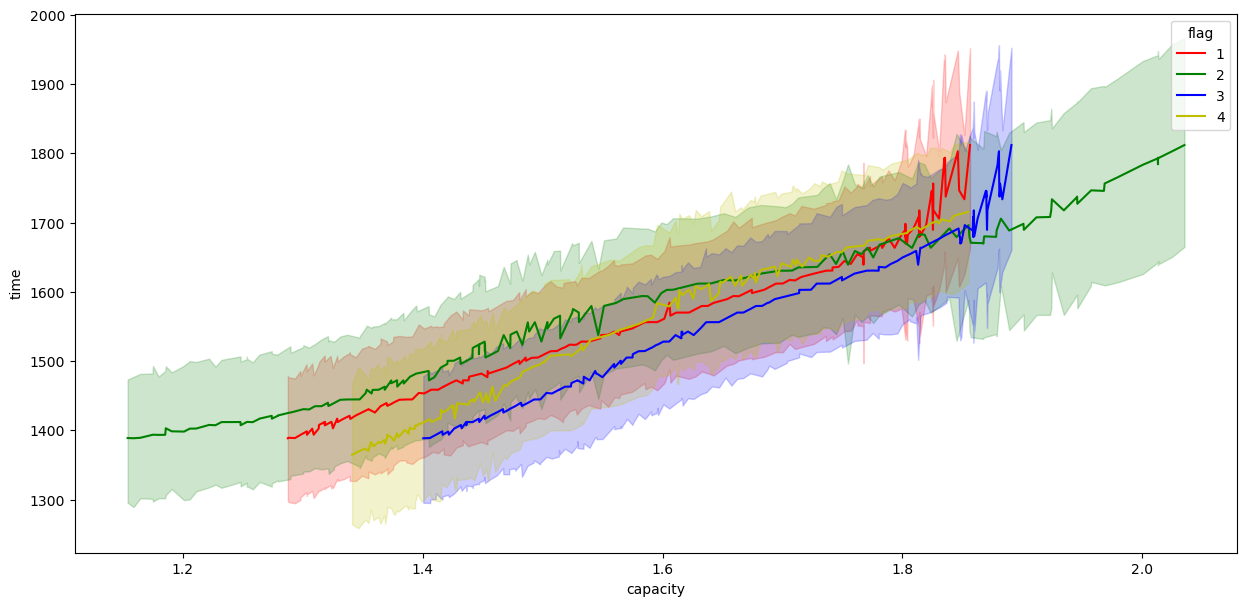

In [29]:
plt.figure(figsize=(15, 7))
sns.lineplot(x = 'capacity', y = 'time', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- 배터리 충전 시간이 늘어남에 따라 4개의 배터리 모두 평균적으로 용량도 증가하고 있습니다.

### 5. Temperature w.r.t time

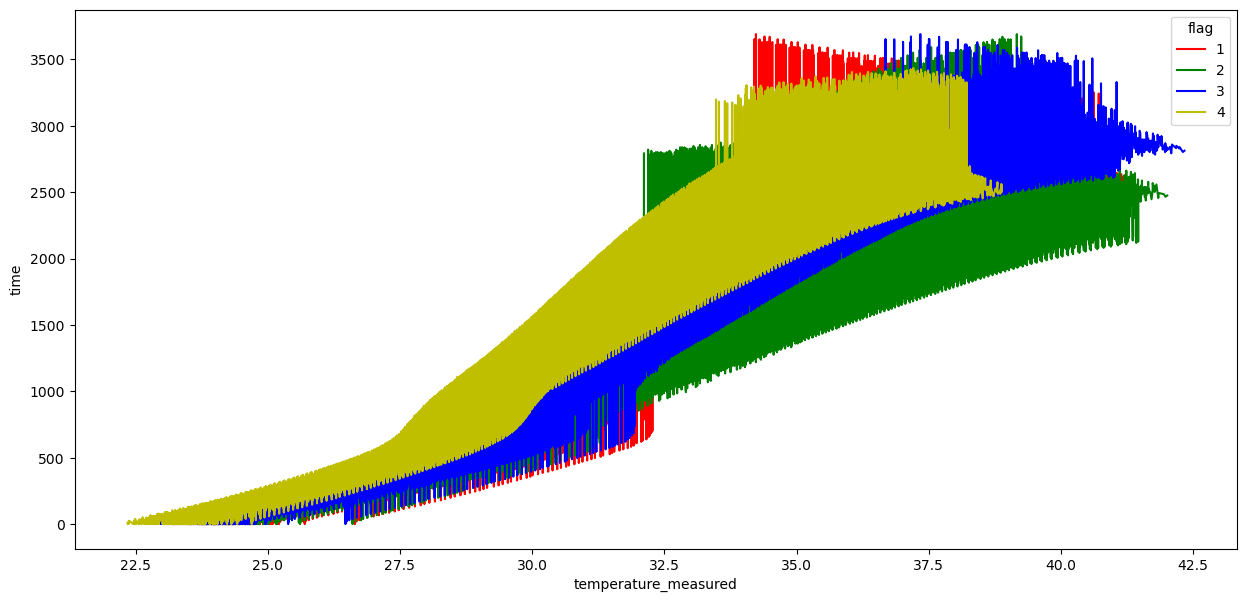

In [30]:
plt.figure(figsize=(15, 7))
sns.lineplot(x = 'temperature_measured', y = 'time', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- 배터리의 시간이 증가함에 따라 감가상각이 증가하는데, 이는 충전 사이클마다 온도_측정값이 증가하기 때문입니다.
- 명확하게 볼 수 있듯이 플래그가 2인 배터리(B0006)의 최대 이상값 수는 다음과 같습니다.

### 6. Voltage measured w.r.t time

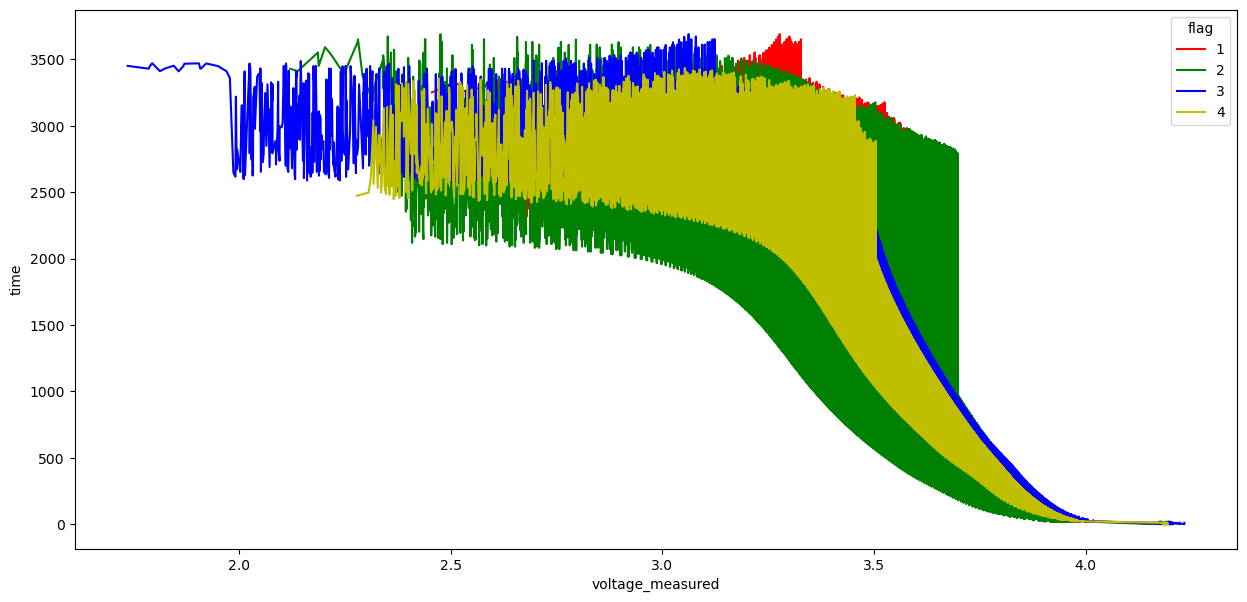

In [31]:
plt.figure(figsize=(15, 7))
sns.lineplot(x = 'voltage_measured', y = 'time', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- 명확하게 볼 수 있듯이 플래그 2가 있는 Batter(B0006)의 최대 이상값 수는 다음과 같습니다.

### 7. Current measured w.r.t time

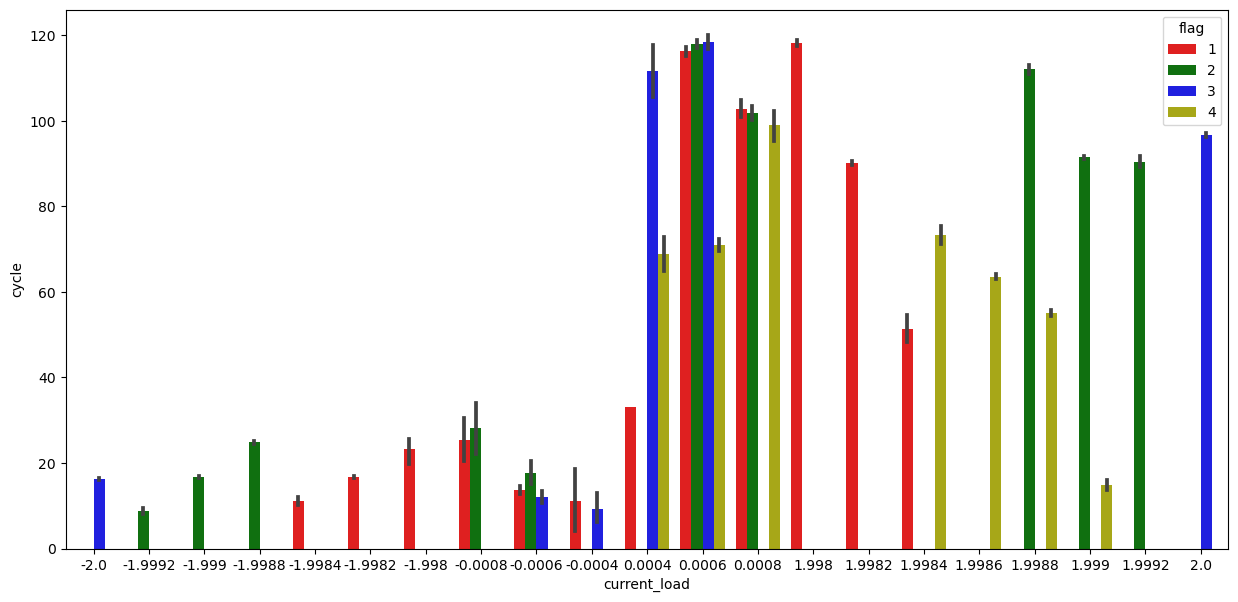

In [32]:
plt.figure(figsize=(15, 7))
sns.barplot(x = 'current_load', y = 'cycle', data = fuel_cells_df, palette = ['r','g','b','y'], hue = 'flag')
plt.show()

- 명확하게 볼 수 있듯이 플래그 2가 있는 Batter(B0006)의 최대 이상값 수는 다음과 같습니다.

### 8. Correlation between various features

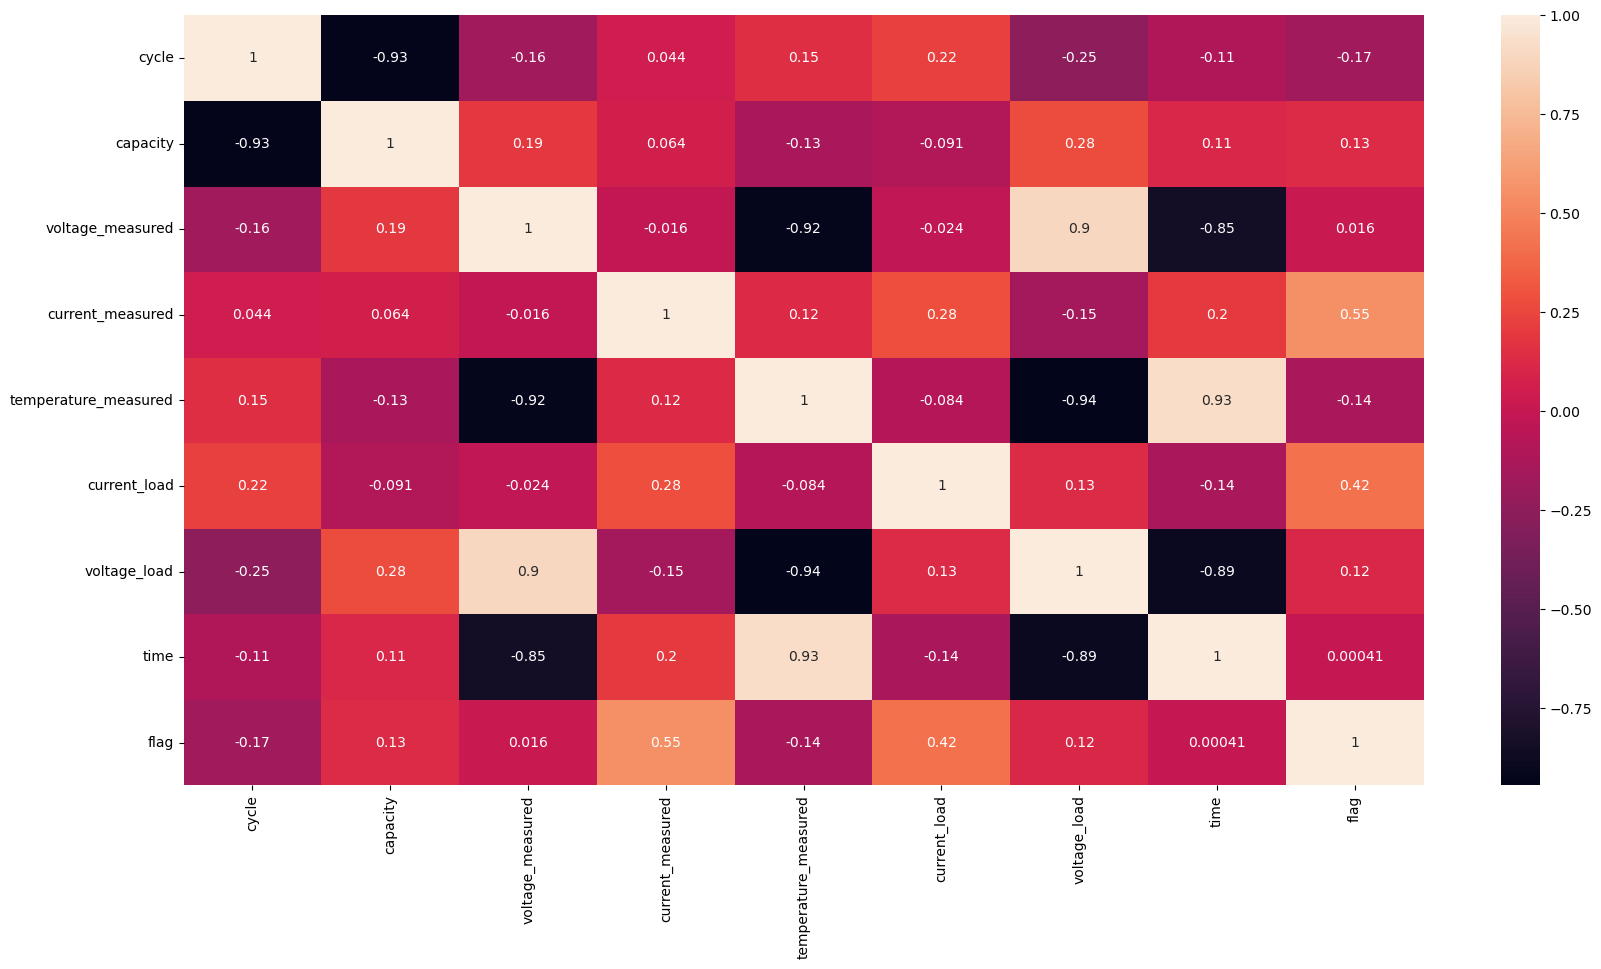

In [33]:
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(fuel_cells_df.corr(method = 'spearman'), annot = True)
plt.show()

- cycle, capacity -> 음의 상관관계.
- volatage load, voltage_measured -> 음의 상관관계.
- voltage_measured, time -> 양의 상관관계.
- temperature, time -> 양의 상관관계.

In [34]:
fuel_cells_df.shape

(185721, 10)

In [35]:
fuel_cells_df.drop_duplicates(keep = 'first', inplace = True)
fuel_cells_df.shape

(185721, 10)

In [36]:
fuel_cells_df.dropna(inplace = True)

In [37]:
fuel_cells_df.shape

(185721, 10)

In [38]:
fuel_cells_df.columns

Index(['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

# 기존의 이상 징후 탐지 방법을 사용한 시각적 분석( IQR and DBSCAN )

## 1. IQR 기반 이상 징후 탐지

In [39]:
num_cols_1 = ['capacity', 'voltage_measured','voltage_load']

In [40]:
num_cols_2 = ['current_measured','current_load']
temp = ['temperature_measured']

In [41]:
num_cols_3 = ['cycle','time']

In [42]:
Q1 = fuel_cells_df.quantile(0.25)
Q3 = fuel_cells_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

cycle                     75.000000
capacity                   0.315825
voltage_measured           0.278098
current_measured           0.021444
temperature_measured       5.850056
current_load               0.000800
voltage_load               0.308000
time                    1542.688000
flag                       2.000000
dtype: float64


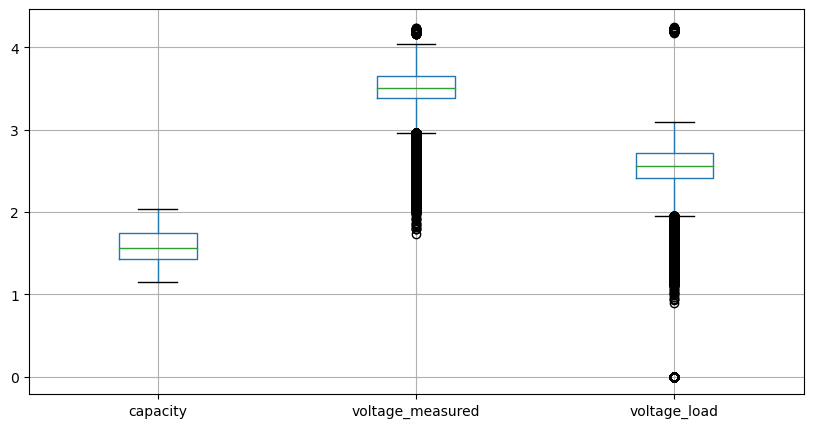

In [43]:
fuel_cells_df[num_cols_1].boxplot(figsize = (10,5))
plt.show()

#### - 'voltage_measured','voltage_load' 더 많은 이상치 관찰 (박스 플롯 하단 다중 분포)

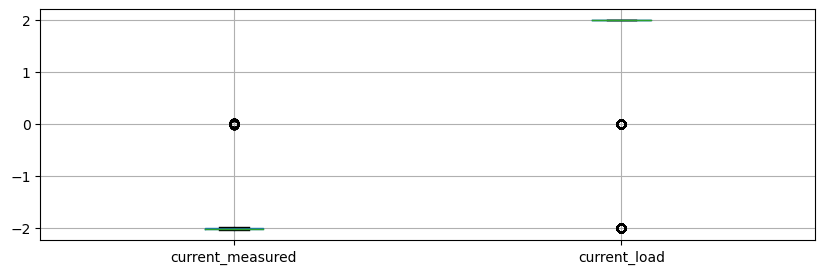

In [44]:
fuel_cells_df[num_cols_2].boxplot( figsize = (10,3))
plt.show()

#### - 데이터 포인트가 적기 때문에 IQR 범위가 매우 작지만 'current_measured', 'current_load'에 대해 일부 이상값이 존재함

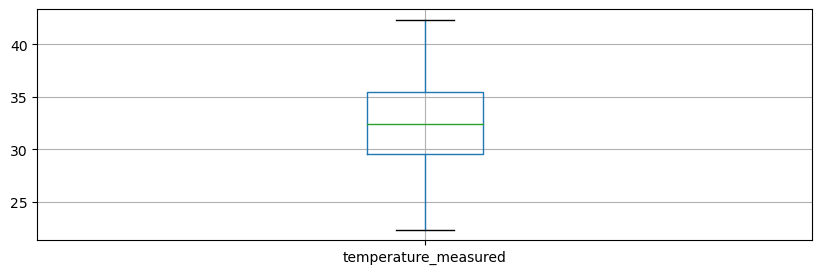

In [45]:
fuel_cells_df[temp].boxplot(figsize = (10,3))
plt.show()

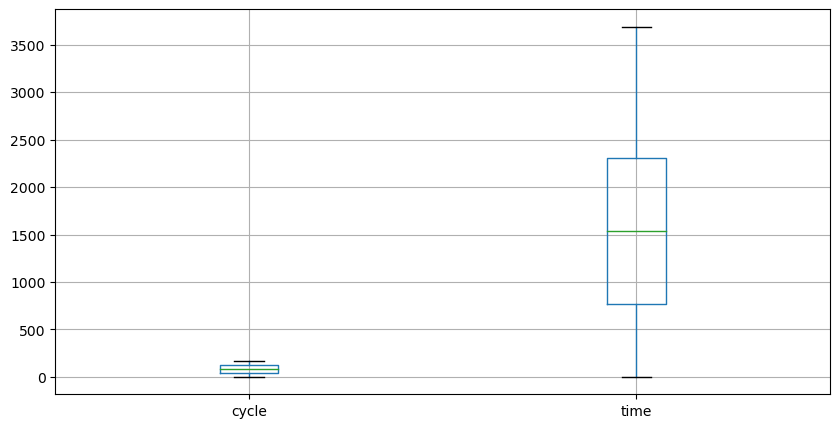

In [46]:
fuel_cells_df[num_cols_3].boxplot(figsize = (10,5))
plt.show()

- 다른 모든 기능은 이상값이 매우 적습니다.

In [47]:
num_cols = ['cycle','capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time']

In [48]:
fuel_cells_df.shape

(185721, 10)

In [49]:
fuel_cells_df1 = fuel_cells_df.copy()

### IQR 기반 방법을 사용한 이상값 처리

In [50]:
fuel_cells_df1 = fuel_cells_df1[~((fuel_cells_df1[num_cols] < (Q1 - 1.5*IQR)) | (fuel_cells_df1[num_cols] > (Q3 +1.5*IQR))).any(axis = 1)]
fuel_cells_df1 = fuel_cells_df1.reset_index(drop = True)

In [51]:
fuel_cells_df1.shape

(147955, 10)

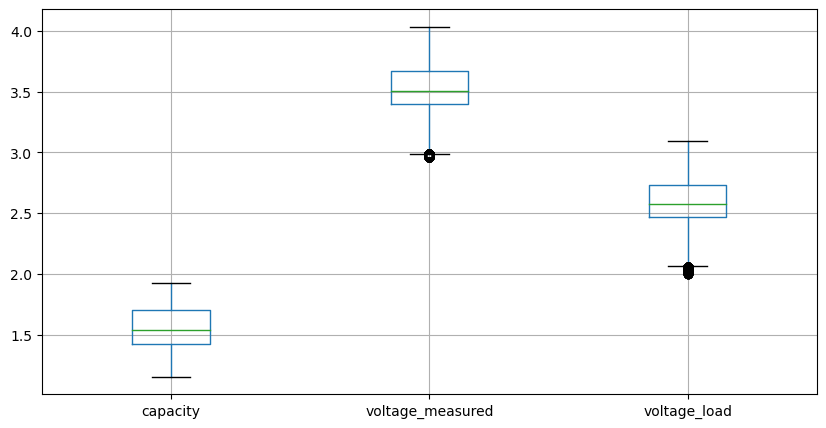

In [52]:
fuel_cells_df1[num_cols_1].boxplot(figsize = (10,5))
plt.show()

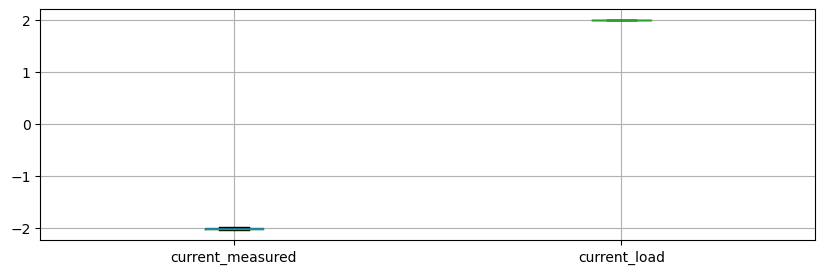

In [53]:
fuel_cells_df1[num_cols_2].boxplot(figsize = (10,3))
plt.show()

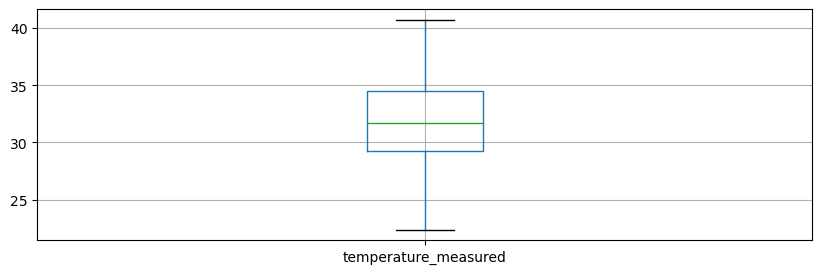

In [54]:
fuel_cells_df1[temp].boxplot(figsize = (10,3))
plt.show()

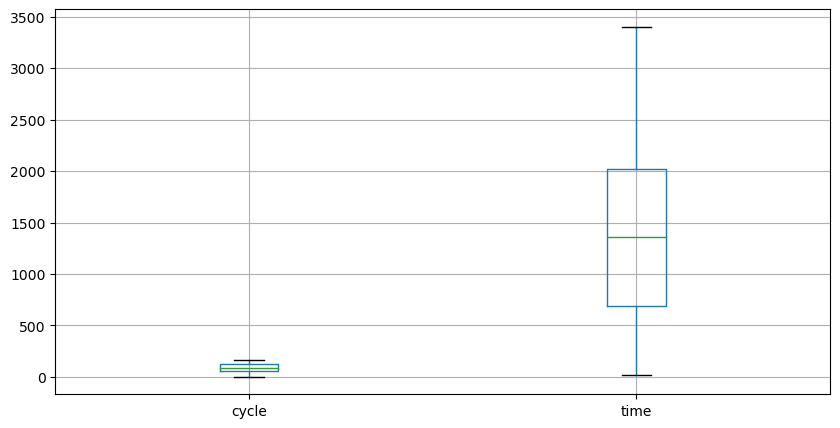

In [55]:
fuel_cells_df1[num_cols_3].boxplot(figsize = (10,5))
plt.show()

In [56]:
fuel_cells_df1.shape[0] - fuel_cells_df.shape[0]

-37766

- 보시다시피, 총 37,766개의 데이터 포인트가 IQR 기반 방법을 사용하여 제거되었습니다.
- 여기에는 유용한 데이터도 포함될 수 있으므로 이상값을 처리/탐지할 때는 강력한 이상값 탐지 방법인 SOTA를 사용하는 것이 좋습니다.

In [57]:
# copy before mormalization and before datetime converson to int
fuel_cells_df_copy1 = fuel_cells_df.copy()

In [58]:
fuel_cells_df['datetime'] = fuel_cells_df['datetime'].astype('int64')
fuel_cells_df['datetime'].head()

0    1207149941000000000
1    1207149941000000000
2    1207149941000000000
3    1207149941000000000
4    1207149941000000000
Name: datetime, dtype: int64

In [59]:
# copy before mormalization and after datetime converson to int
fuel_cells_df_copy2 = fuel_cells_df.copy()

## 2. DBSCAN 기반 이상치 탐지

 - 위의 IQR 방법에서 알 수 있듯이 1.85 lac 데이터 포먼트에서 약 37,000 개의 이상값이 있음을 알았으므로 하이퍼 파라미터 (eps 및 minpts)를 신중하게 시도했습니다.
 - 여러 가지 eps 및 minpts 값으로 시도한 결과, minpts = 200 및 eps = 0.5를 사용하면 최상의 결과를 얻을 수 있다는 결론에 도달했습니다 (샘플링 (나중에 10k 데이터 포인트 사용) 및 대체를 통한 부트 스트랩과 결과 비교).

In [60]:
# DBSCAn on entire dataset

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

cols = ['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag']



std_scaler = StandardScaler().fit(fuel_cells_df_copy2)
std_df = std_scaler.transform(fuel_cells_df_copy2)

dbsc = DBSCAN(eps = .5, min_samples = 200).fit(std_df)


labels = dbsc.labels_

 


In [62]:
out_df = fuel_cells_df_copy2.copy()
out_df['label'] = dbsc.labels_

In [63]:
out_df['label'].value_counts()

 7     41653
 1     39215
 4     37784
 9     31107
-1      8122
 6      5378
 3      5265
 0      5188
 5      4833
 2      4203
 10     1922
 8      1051
Name: label, dtype: int64

In [64]:
count_df = pd.DataFrame(data = out_df['label'].value_counts().values, columns = ['label_counts'])
count_df

label_counts
0          41653
1          39215
2          37784
3          31107
4           8122
5           5378
6           5265
7           5188
8           4833
9           4203
10          1922
11          1051

In [65]:
index_df = pd.DataFrame(data = out_df['label'].value_counts().index, columns = ['label_index'])
index_df

label_index
0             7
1             1
2             4
3             9
4            -1
5             6
6             3
7             0
8             5
9             2
10           10
11            8

In [66]:
label_counts_df = pd.concat([index_df,count_df], axis = 1)
label_counts_df

label_index  label_counts
0             7         41653
1             1         39215
2             4         37784
3             9         31107
4            -1          8122
5             6          5378
6             3          5265
7             0          5188
8             5          4833
9             2          4203
10           10          1922
11            8          1051

In [67]:
out_df

cycle             datetime  capacity  voltage_measured  \
0           1  1207149941000000000  1.856487          4.191492   
1           1  1207149941000000000  1.856487          4.190749   
2           1  1207149941000000000  1.856487          3.974871   
3           1  1207149941000000000  1.856487          3.951717   
4           1  1207149941000000000  1.856487          3.934352   
...       ...                  ...       ...               ...   
185716    132  1219221439000000000  1.341051          3.443760   
185717    132  1219221439000000000  1.341051          3.453271   
185718    132  1219221439000000000  1.341051          3.461963   
185719    132  1219221439000000000  1.341051          3.469907   
185720    132  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  label  
0          0.000     1     -1  
1         16.781     1     -1  
2         35.703     1      0  
3         53.781     1      0  
4         71.922     1      0  
...          ...   ...    ...  
185716  2686.359     4     10  
185717  2700.546     4     10  
185718  2714.640     4     10  
185719  2728.750     4     10  
185720  2742.843     4     10  

[185721 rows x 11 columns]

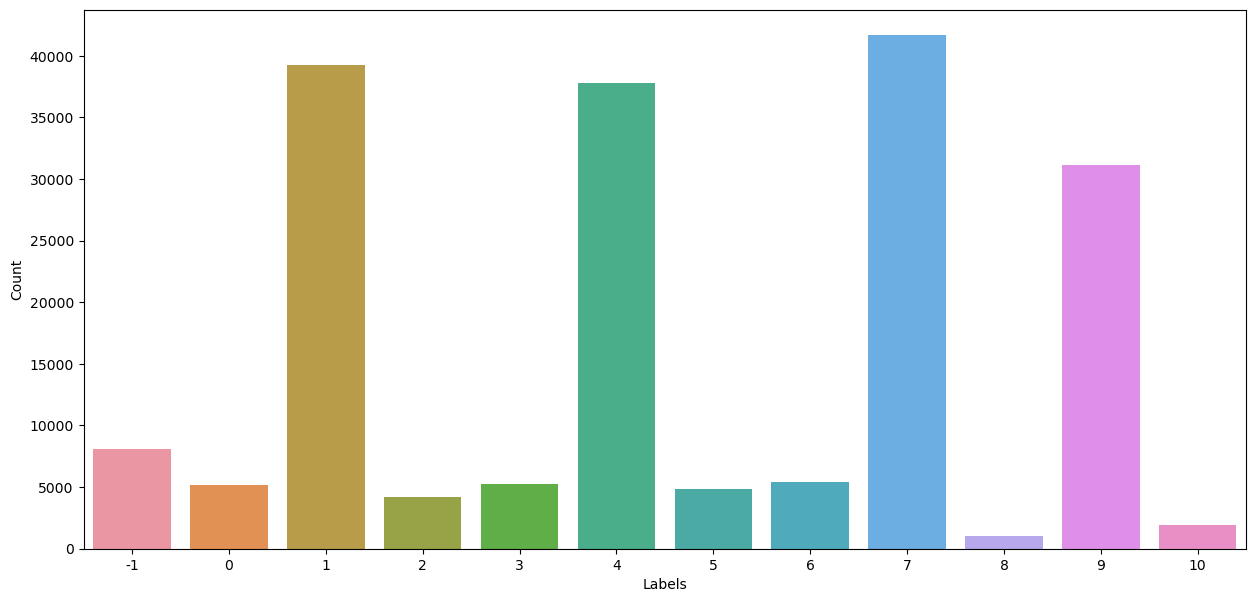

In [68]:
plt.figure(figsize=(15, 7))
sns.barplot(x =  'label_index', y = 'label_counts', data = label_counts_df)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

- 보시다시피, 모든 특징을 고려했을 때 -1(노이즈 데이터)에 해당하는 데이터 포인트는 8009개입니다.
- 다른 두 가지 특징에 대해 시각화 및 DBSCAN으로 추가로 확인해 보겠습니다.
- 매우 높은 시간 복잡성으로 실행되고 있으므로 10,000개의 샘플로 시각화했습니다.

### 차원 축소 시각화 (2 features)

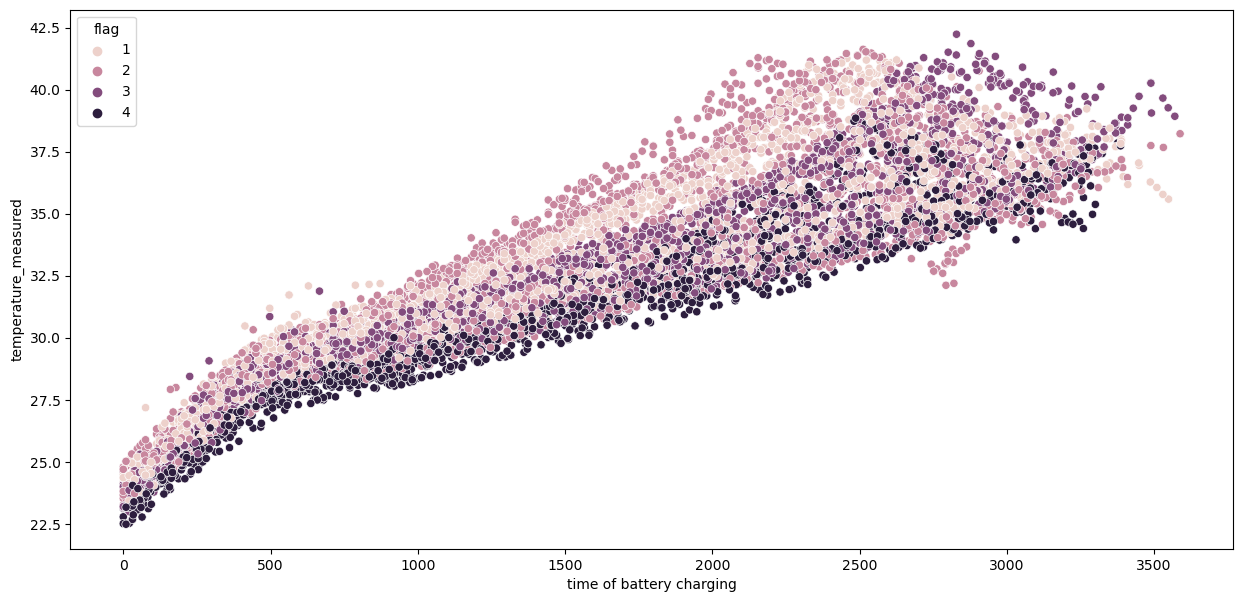

In [69]:
# Let's plot two features data now for viz
plt.figure(figsize=(15, 7))
sns.scatterplot(x = 'time', y = 'temperature_measured', hue ='flag', data = out_df.sample(n = 10000, replace = True))
plt.xlabel('time of battery charging')
plt.ylabel('temperature_measured')
plt.show()

- 이 두 가지 기능으로 시각화하면 이상값이 거의 보이지 않습니다.
- 다른 두 가지 기능으로 교차 확인해 보겠습니다.

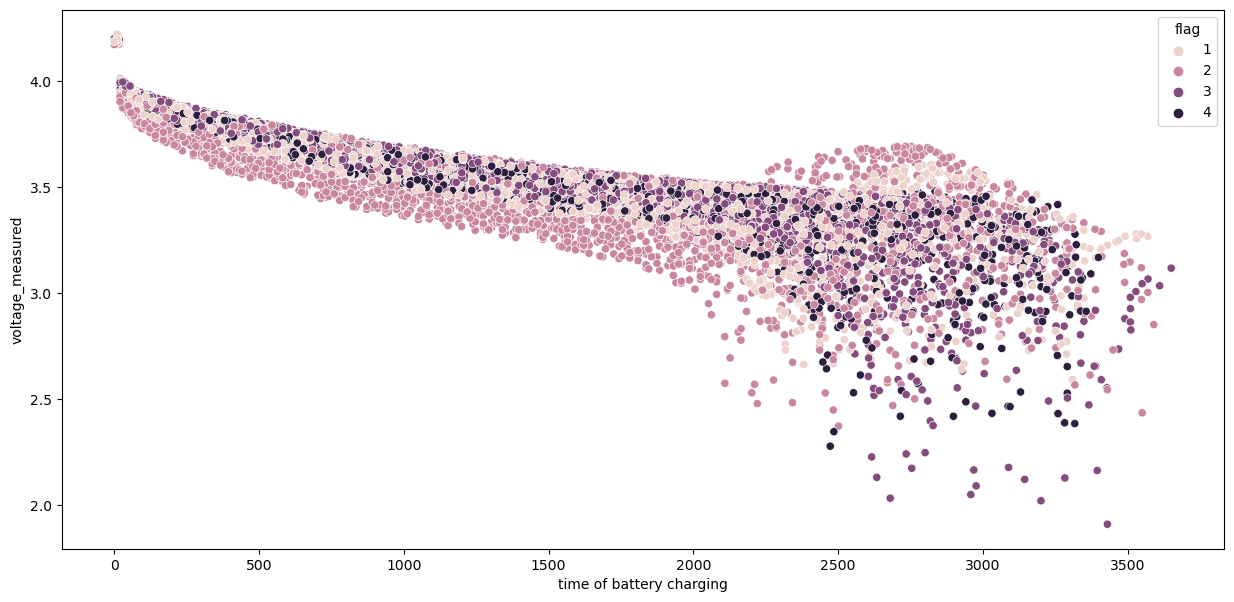

In [70]:
# Let's plot different two features data now for viz
plt.figure(figsize=(15, 7))
sns.scatterplot(x = 'time', y = 'voltage_measured', hue ='flag', data = out_df.sample(n = 10000, replace = True))
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics


df = fuel_cells_df_copy2[['time','voltage_measured']].sample(n = 10000, replace = True)

std_scaler = StandardScaler().fit(df)
std_df = std_scaler.transform(df)

dbsc = DBSCAN(eps = .5, min_samples = 200).fit(std_df)


labels = dbsc.labels_

In [72]:
out_df = df.copy()
out_df['label'] = dbsc.labels_

In [73]:
out_df['label'].value_counts()

 0    9725
-1     275
Name: label, dtype: int64

In [74]:
out_df

time  voltage_measured  label
160509   618.781          3.735628      0
21537    375.579          3.794127      0
135436  1068.750          3.573766      0
146314  2305.844          3.275077      0
31684    787.282          3.624449      0
...          ...               ...    ...
113253   666.078          3.746185      0
134872  1640.187          3.471914      0
36089    788.094          3.613416      0
108869  1059.328          3.659536      0
14589   2155.531          3.468564      0

[10000 rows x 3 columns]

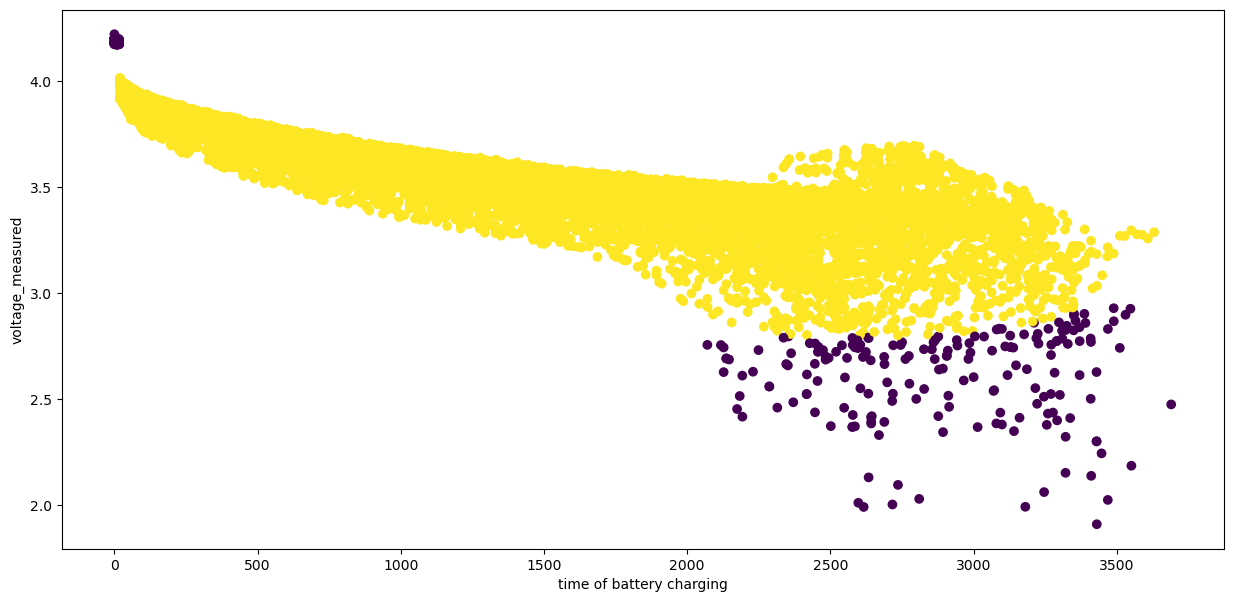

In [75]:
plt.figure(figsize=(15, 7))
plt.scatter(out_df['time'], out_df['voltage_measured'], c=out_df['label'])
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

- DBSCAN을 사용하면 노이즈 포인트의 클러스터를 보라색으로 명확하게 볼 수 있습니다.
- 총 이상값 수는 8009개입니다.

In [76]:
fuel_cells_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185721 entries, 0 to 185720
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cycle                 185721 non-null  int64  
 1   datetime              185721 non-null  int64  
 2   capacity              185721 non-null  float64
 3   voltage_measured      185721 non-null  float64
 4   current_measured      185721 non-null  float64
 5   temperature_measured  185721 non-null  float64
 6   current_load          185721 non-null  float64
 7   voltage_load          185721 non-null  float64
 8   time                  185721 non-null  float64
 9   flag                  185721 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 15.6 MB


### 원본 데이터 최소 스케일링

In [77]:

cols = ['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag']
mm_scaler = MinMaxScaler()

fuel_cells_df[cols] = mm_scaler.fit_transform(fuel_cells_df[cols])
fuel_cells_df.head()

cycle  datetime  capacity  voltage_measured  current_measured  \
0    0.0       0.0  0.797111          0.983242          0.990600   
1    0.0       0.0  0.797111          0.982944          0.992276   
2    0.0       0.0  0.797111          0.896465          0.008109   
3    0.0       0.0  0.797111          0.887189          0.007399   
4    0.0       0.0  0.797111          0.880233          0.008787   

   temperature_measured  current_load  voltage_load      time  flag  
0              0.099077       0.49985      0.000000  0.000000   0.0  
1              0.098875       0.49985      0.989880  0.004547   0.0  
2              0.102032       0.00045      0.720640  0.009675   0.0  
3              0.109822       0.00045      0.713109  0.014574   0.0  
4              0.119162       0.00045      0.708637  0.019490   0.0

## 3. Isolation Forest 기반 이상치 탐지

Isolation Forest의 개별 트리는 임의의 특징과 임의의 임계값을 선택하고 이를 기반으로 데이터를 분할합니다. 정상 지점보다 낮은 깊이에서 이상값이 발견될 것으로 예상합니다.

In [78]:
fuel_cells_df['flag'].unique()

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [79]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

flag_df = pd.DataFrame()
flag_df_final = pd.DataFrame()
for j in fuel_cells_df['flag'].unique():
    contamination_arr = [0.01, 0.02, 0.03, 0.04]
    flag_df = fuel_cells_df[fuel_cells_df['flag'] == j]
    for i in contamination_arr:
        model = IsolationForest(n_estimators = 200, max_samples = 'auto', contamination = i, random_state = 42)
        
        # Create a variable holding the relevant columns for fitting the model and decision_function
        feature_columns = flag_df.columns.difference(['anomaly_score'+'_'+str(i)])

        flag_df['anomaly_score'+'_'+str(i)] = model.fit_predict(flag_df[feature_columns])
        flag_df['scores'+'_'+str(i)] = model.decision_function(flag_df[feature_columns])
    flag_df_final = pd.concat([flag_df,flag_df_final])

In [80]:
# flag_df

In [81]:
flag_df_final['anomaly_score_0.01'].value_counts(ascending= True)

-1      1858
 1    183863
Name: anomaly_score_0.01, dtype: int64

In [82]:
for i in contamination_arr:
    print(f'Anomalies with contamination {i}:',len(flag_df_final[flag_df_final['anomaly_score'+'_'+str(i)] == -1]))

Anomalies with contamination 0.01: 1858
Anomalies with contamination 0.02: 3716
Anomalies with contamination 0.03: 5573
Anomalies with contamination 0.04: 7431


In [83]:
## Data before normalization merging with new:
fuel_cells_df_final = pd.concat([fuel_cells_df_copy2, flag_df_final.drop(columns=fuel_cells_df.columns)], axis = 1)

In [84]:
df_final_copy = fuel_cells_df_final.copy()

In [85]:
fuel_cells_df_final

cycle             datetime  capacity  voltage_measured  \
0           1  1207149941000000000  1.856487          4.191492   
1           1  1207149941000000000  1.856487          4.190749   
2           1  1207149941000000000  1.856487          3.974871   
3           1  1207149941000000000  1.856487          3.951717   
4           1  1207149941000000000  1.856487          3.934352   
...       ...                  ...       ...               ...   
185716    132  1219221439000000000  1.341051          3.443760   
185717    132  1219221439000000000  1.341051          3.453271   
185718    132  1219221439000000000  1.341051          3.461963   
185719    132  1219221439000000000  1.341051          3.469907   
185720    132  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  anomaly_score_0.01  scores_0.01  anomaly_score_0.02  \
0          0.000     1                  -1    -0.059726                  -1   
1         16.781     1                  -1    -0.052571                  -1   
2         35.703     1                   1     0.017440                  -1   
3         53.781     1                   1     0.020416                  -1   
4         71.922     1                   1     0.025922                  -1   
...          ...   ...                 ...          ...                 ...   
185716  2686.359     4                   1     0.007127                  -1   
185717  2700.546     4                   1     0.010967                  -1   
185718  2714.640     4                   1     0.013077                  -1   
185719  2728.750     4                   1     0.006906                  -1   
185720  2742.843     4                   1     0.007542                  -1   

        scores_0.02  anomaly_score_0.03  scores_0.03  anomaly_score_0.04  \
0         -0.124594                  -1    -0.164764                  -1   
1         -0.118582                  -1    -0.156560                  -1   
2         -0.018445                  -1    -0.081427                  -1   
3         -0.019620                  -1    -0.080311                  -1   
4         -0.017337                  -1    -0.078967                  -1   
...             ...                 ...          ...                 ...   
185716    -0.011005                  -1    -0.064259                  -1   
185717    -0.006013                  -1    -0.055652                  -1   
185718    -0.007058                  -1    -0.052453                  -1   
185719    -0.011095                  -1    -0.059941                  -1   
185720    -0.013075                  -1    -0.063776                  -1   

        scores_0.04  
0         -0.167161  
1         -0.172208  
2         -0.115319  
3         -0.114451  
4         -0.111157  
...             ...  
185716    -0.100642  
185717    -0.094017  
185718    -0.094368  
185719    -0.099099  
185720    -0.100481  

[185721 rows x 18 columns]

### 데이터에 주어진 점수를 시각화하기 위해 점수 플로팅하기

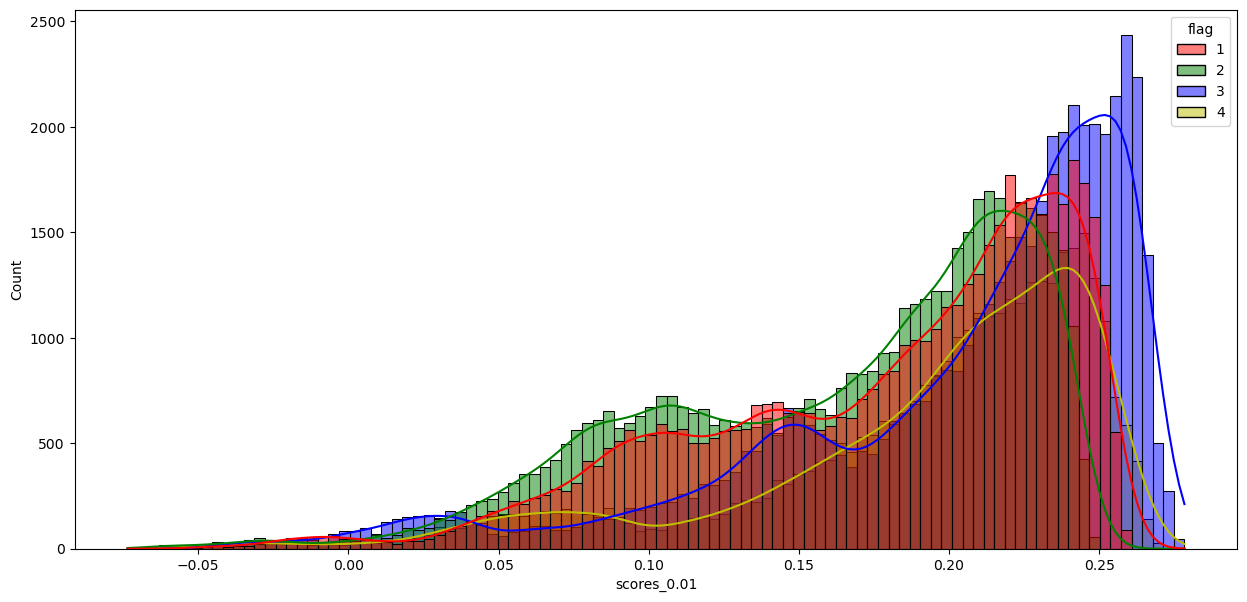

In [86]:
plt.figure(figsize=(15, 7))
sns.histplot(x = 'scores_0.01',hue = 'flag', palette=['r','g','b','y'], data = df_final_copy, bins = 100, kde = True)
fig.show()

- flag 2가 점수에서 최대 확산을 보이고 있으며, 이는 다시 배터리 2의 이상값 수가 최대임을 확인합니다.

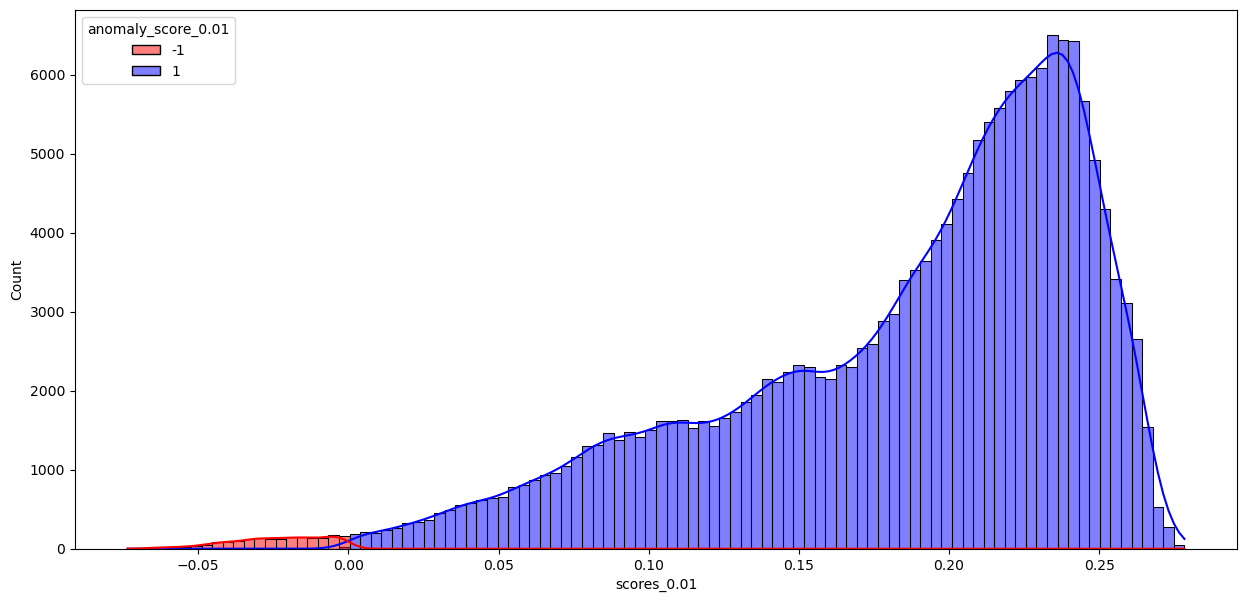

In [87]:
plt.figure(figsize=(15, 7))
sns.histplot(x = 'scores_0.01',hue = 'anomaly_score_0.01', palette=['r','b'], data = df_final_copy, bins = 100, kde = True)
fig.show()

In [88]:
df_final_copy[df_final_copy['anomaly_score_0.01']==-1]['flag'].value_counts()

1    503
2    503
3    503
4    349
Name: flag, dtype: int64

In [89]:
df_final_copy[df_final_copy['anomaly_score_0.04']==-1]['flag'].value_counts()

1    2012
2    2012
3    2012
4    1395
Name: flag, dtype: int64

In [90]:
data = df_final_copy[df_final_copy['anomaly_score_0.01']==-1]

In [91]:
wd = df_final_copy.loc[(df_final_copy['anomaly_score_0.01'] == -1) & (df_final_copy['flag'] == 2)]
len(wd)

503

In [92]:
# Thresholding on scores ( < 0.04)

wd2 = df_final_copy.loc[(df_final_copy['anomaly_score_0.01'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.01']<-0.04)]
len(wd2)

139

In [93]:
# Thresholding on scores ( < 0.05)

wd3 = df_final_copy.loc[(df_final_copy['anomaly_score_0.01'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.01']<-0.05)]
len(wd3)

76

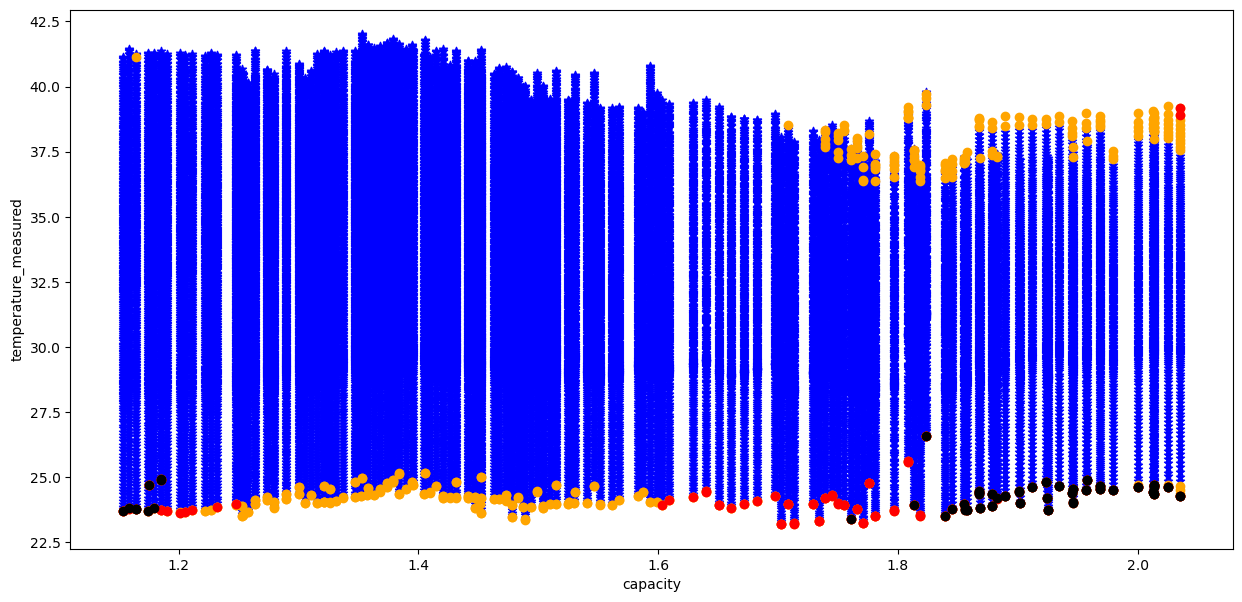

In [94]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['capacity'],
           df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['temperature_measured'], c = 'blue', marker = "*")

plt.scatter(wd['capacity'], wd['temperature_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['capacity'], wd2['temperature_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['capacity'], wd3['temperature_measured'], c = 'black', marker = 'o')

plt.xlabel('capacity')
plt.ylabel('temperature_measured')
plt.show()

- 용량이 훨씬 높은 배터리와 용량이 훨씬 낮지만 최소 온도가 측정된 배터리가 가장 많은 이상값을 가집니다.
- 반면, 온도가 가장 낮게 측정된 배터리는 이상값이 더 많은 배터리입니다.

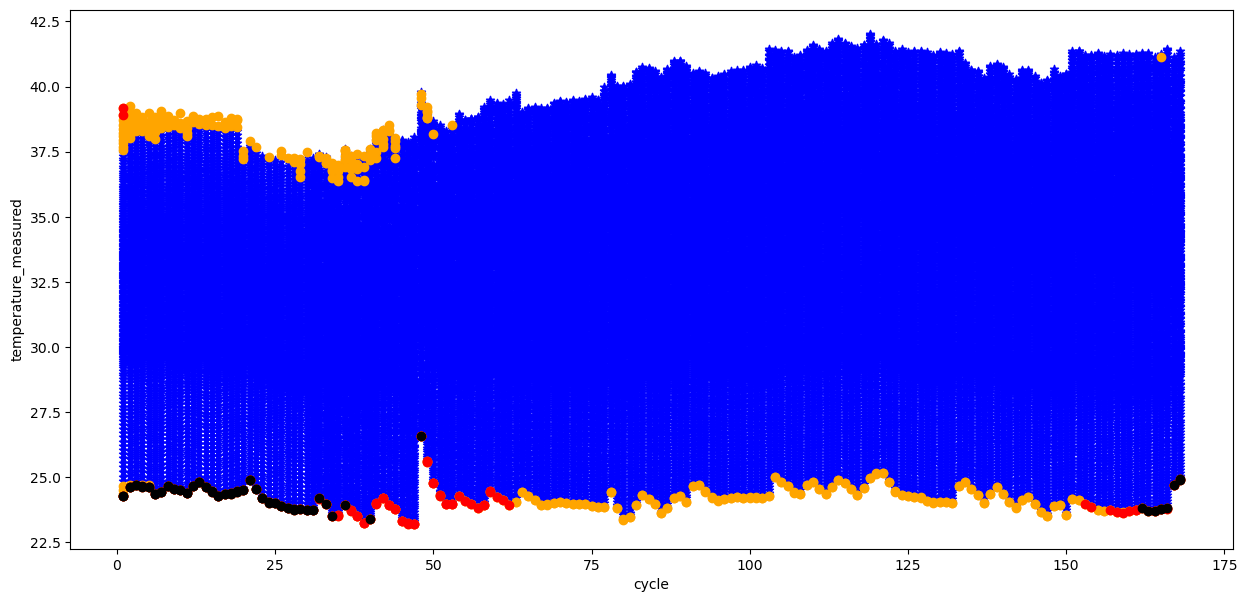

In [95]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['cycle'],
           df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['temperature_measured'], c = 'blue', marker = "*")

plt.scatter(wd['cycle'], wd['temperature_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['cycle'], wd2['temperature_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['cycle'], wd3['temperature_measured'], c = 'black', marker = 'o')

plt.xlabel('cycle')
plt.ylabel('temperature_measured')
plt.show()

- 온도가 가장 적게 측정된 배터리는 이상값이 더 많은 배터리입니다.

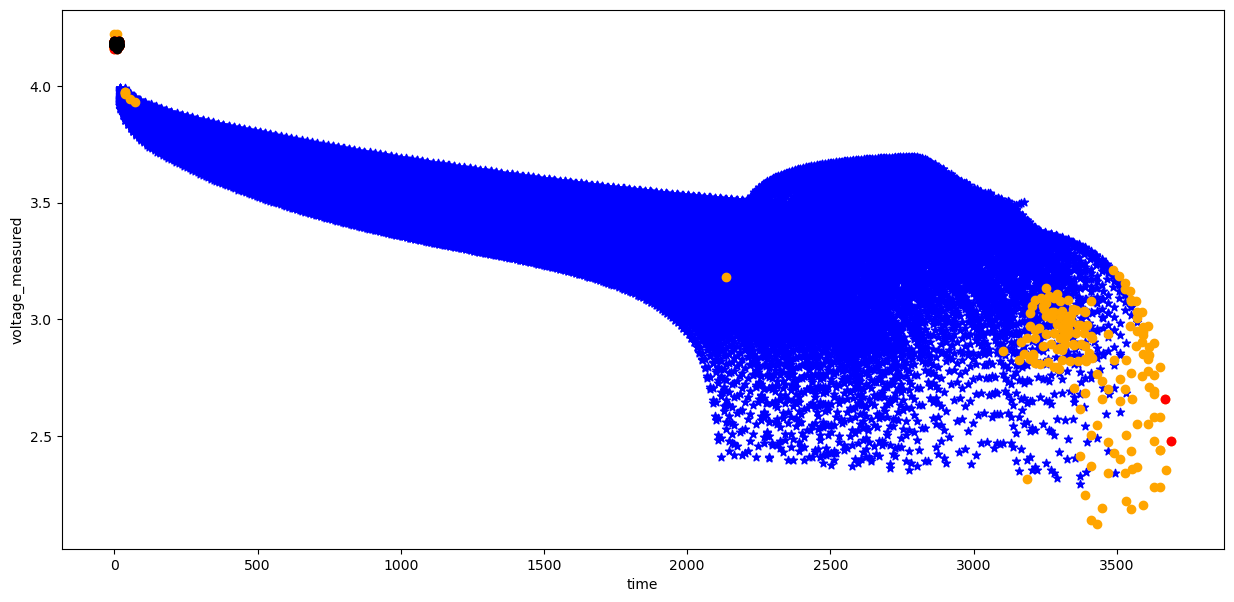

In [96]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['time'],
           df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['voltage_measured'], c = 'blue', marker = "*")

plt.scatter(wd['time'], wd['voltage_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['time'], wd2['voltage_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['time'], wd3['voltage_measured'], c = 'black', marker = 'o')

plt.xlabel('time')
plt.ylabel('voltage_measured')
plt.show()

- 최소 충전 시간으로 최대 전압을 생성하는 배터리 데이터 포인트는 세라틴 이상치/아나몰리에 해당합니다.
- 또한, 오염이 가장 적으면서 충전에 최대 시간이 필요한 배터리 데이터 포인트는 세라틴 이상치/아나몰리에 해당합니다.

### 오염수치 증가한 이상치들

In [97]:
# Testing with multiple values such as with  anomaly_score_0.04

wd = df_final_copy.loc[(df_final_copy['anomaly_score_0.04'] == -1) & (df_final_copy['flag'] == 2)]
wd2 = df_final_copy.loc[(df_final_copy['anomaly_score_0.04'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.04']<-0.04)]
wd3 = df_final_copy.loc[(df_final_copy['anomaly_score_0.04'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.04']<-0.05)]
        

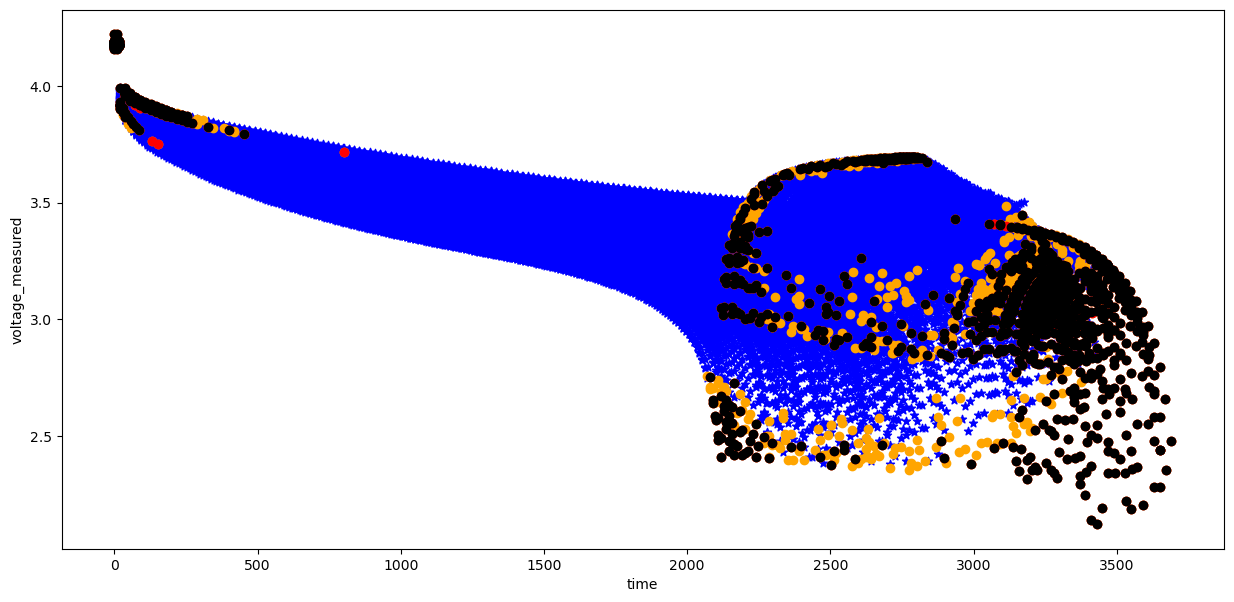

In [98]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.04'] == 1) & (df_final_copy['flag'] == 2)]['time'],
           df_final_copy[(df_final_copy['anomaly_score_0.04'] == 1) & (df_final_copy['flag'] == 2)]['voltage_measured'], c = 'blue', marker = "*")

plt.scatter(wd['time'], wd['voltage_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['time'], wd2['voltage_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['time'], wd3['voltage_measured'], c = 'black', marker = 'o')

plt.xlabel('time')
plt.ylabel('voltage_measured')
plt.show()

- 이상값의 오염도를 4%로 높이면, 1%의 오염도와 비교하여 시각적으로 보이는 아나몰리를 이상값으로 분류할 수 있습니다.
- 또한 최대 오염도가 4%인 경우, 충전에 최대 시간이 필요하고 전압이 낮은 배터리 데이터 포인트는 세라틴 이상치/아나몰리에 해당합니다.

In [99]:
flags_arr = [1,2,3,4]
contamination_arr = [0.01,0.02,0.03,0.04]

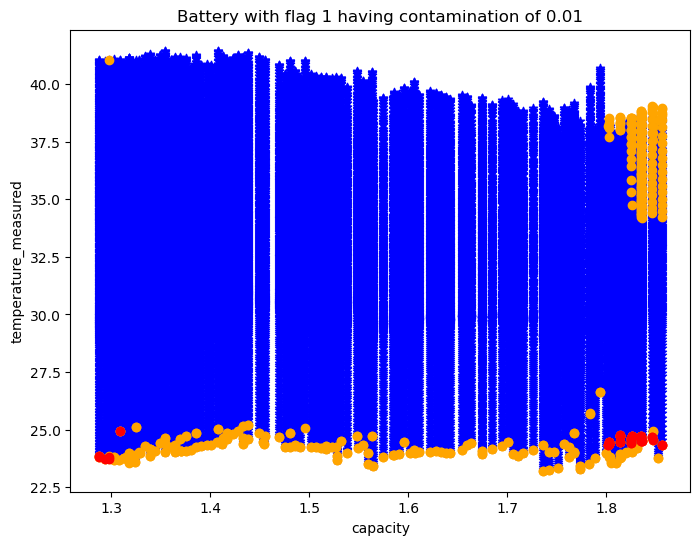

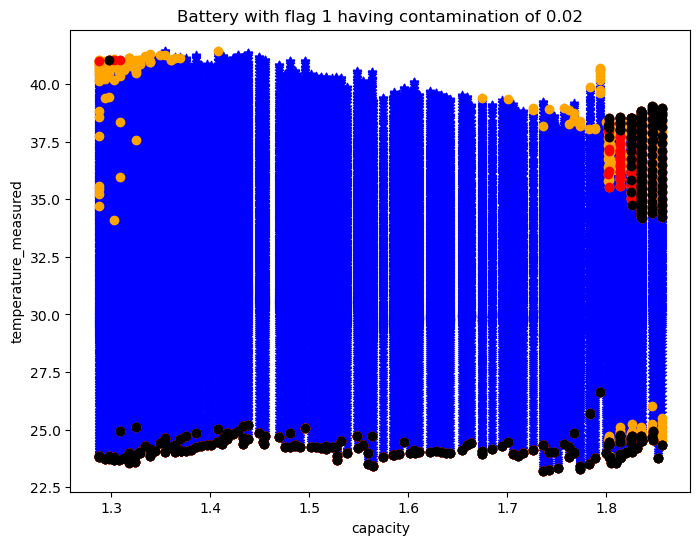

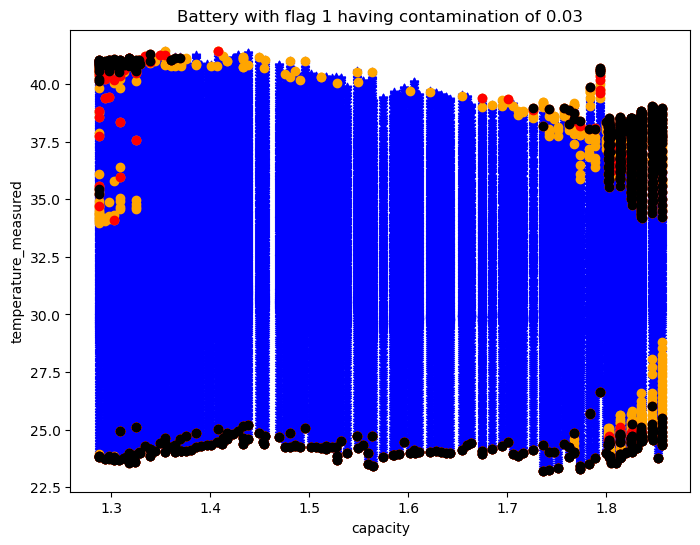

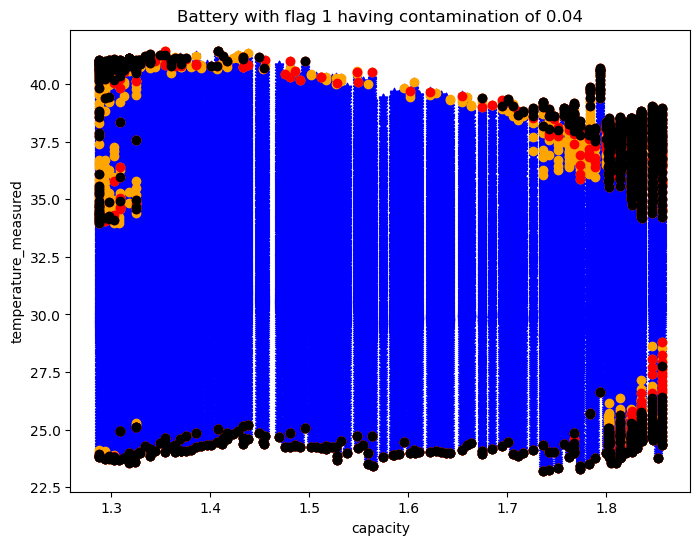

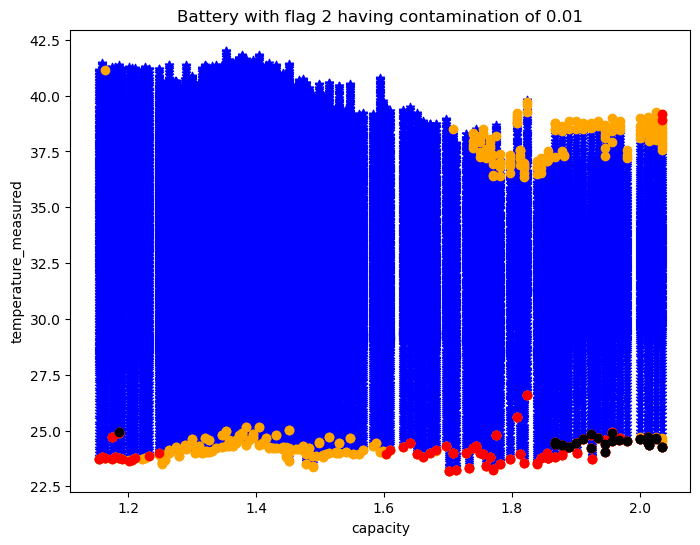

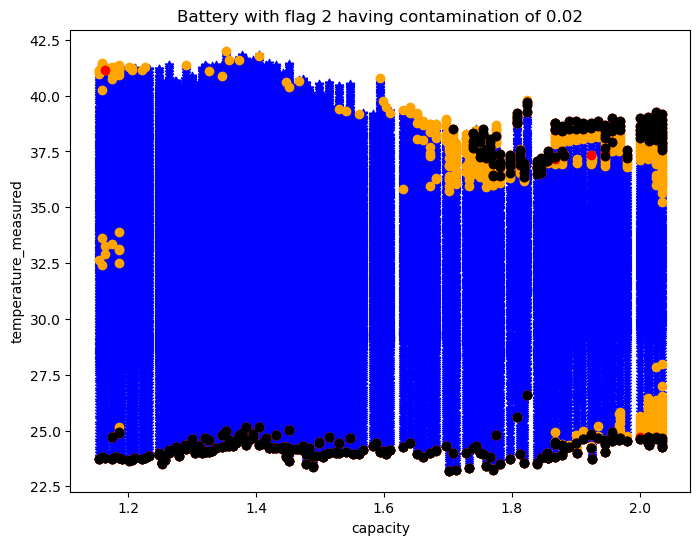

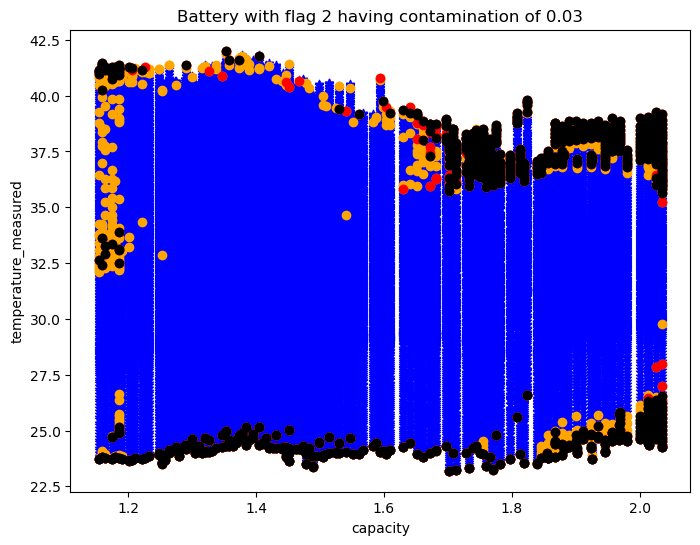

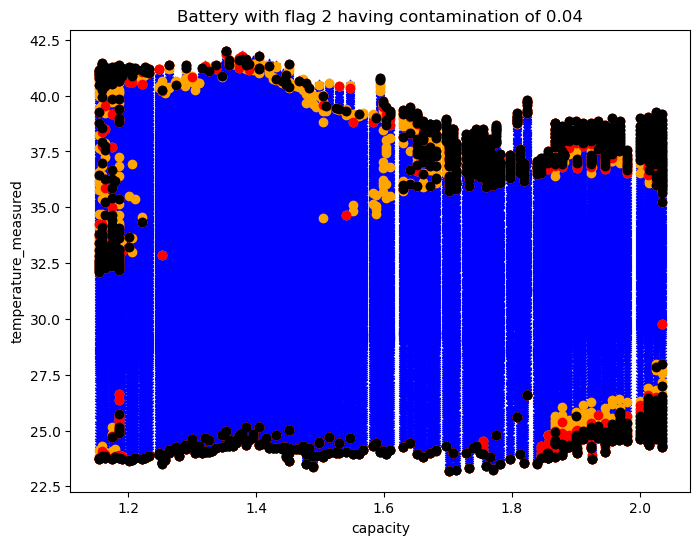

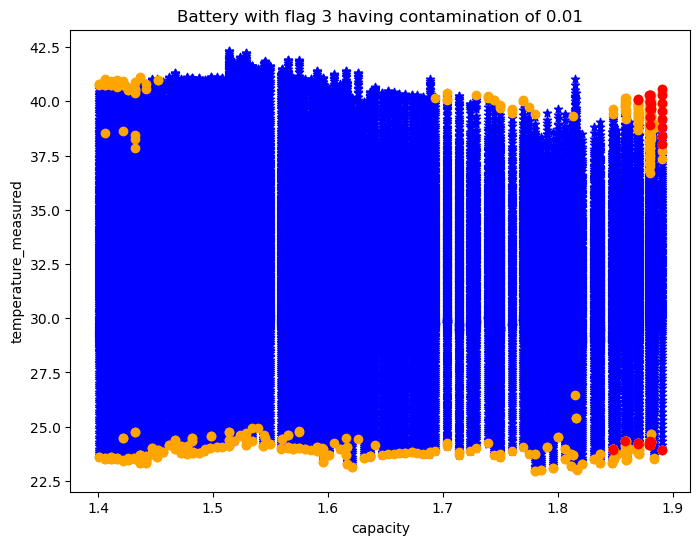

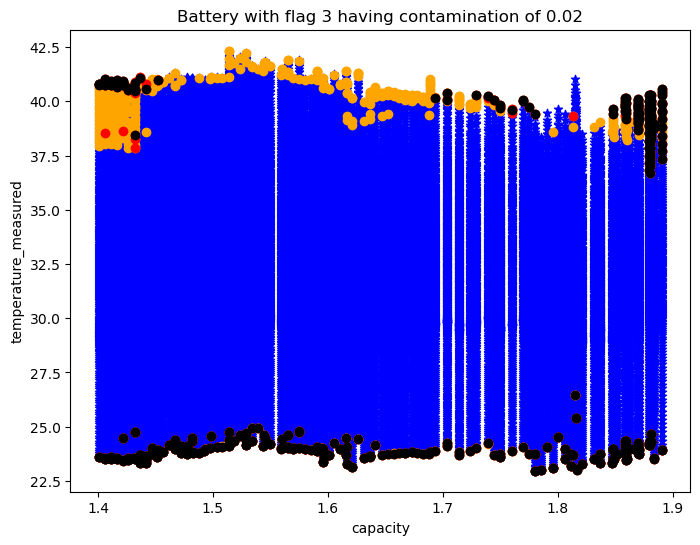

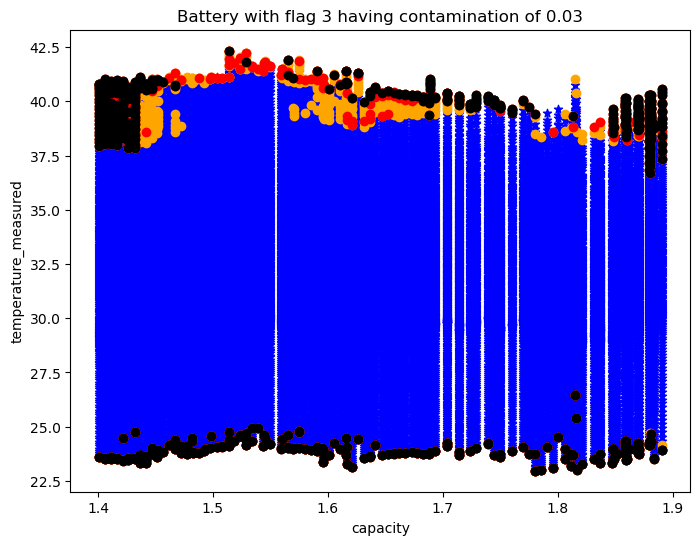

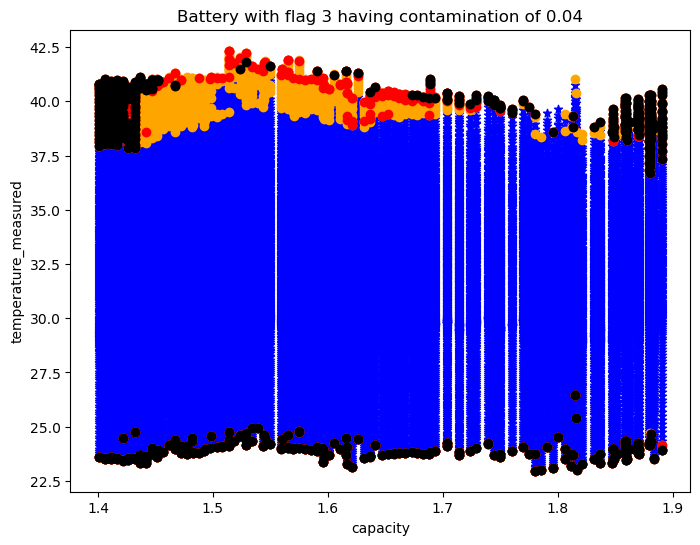

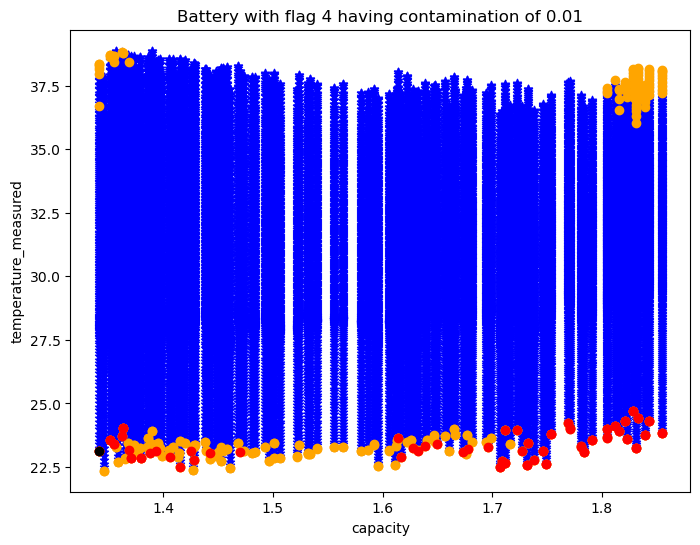

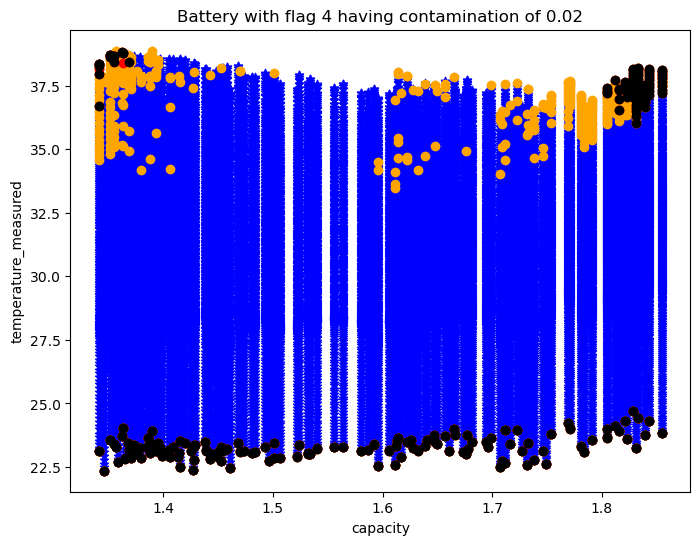

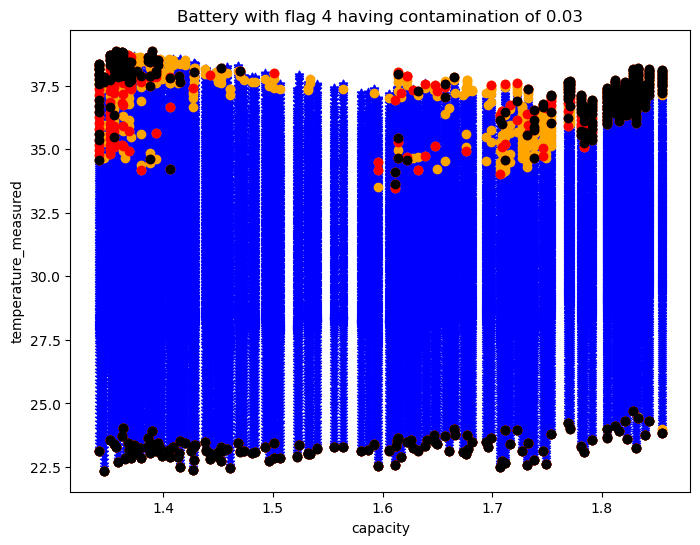

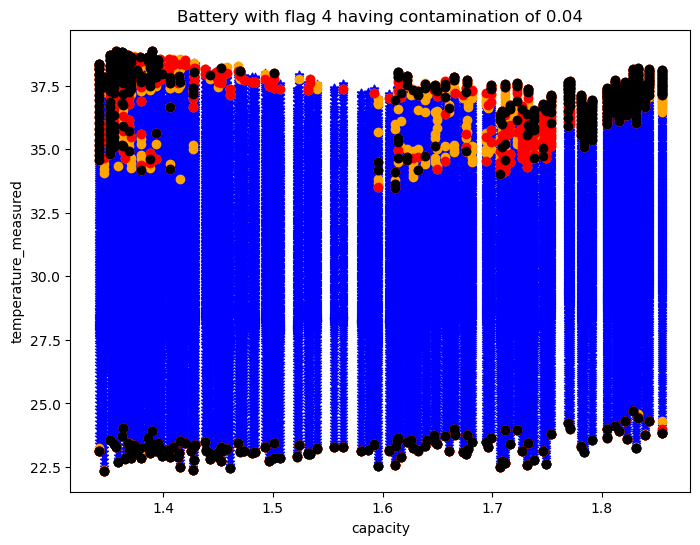

In [100]:
for i in flags_arr:
    for j in contamination_arr:
        wd = df_final_copy.loc[(df_final_copy['anomaly_score'+'_'+str(j)] == -1) & (df_final_copy['flag'] == i)]
        wd2 = df_final_copy.loc[(df_final_copy['anomaly_score'+'_'+str(j)] == -1) & (df_final_copy['flag'] == i) & (df_final_copy['scores'+'_'+str(j)]<-0.04)]
        wd3 = df_final_copy.loc[(df_final_copy['anomaly_score'+'_'+str(j)] == -1) & (df_final_copy['flag'] == i) & (df_final_copy['scores'+'_'+str(j)]<-0.06)]
        
        plt.figure(figsize=(8, 6))
        plt.scatter(df_final_copy[(df_final_copy['anomaly_score'+'_'+str(j)] == 1) & (df_final_copy['flag'] == i)]['capacity'],
                   df_final_copy[(df_final_copy['anomaly_score'+'_'+str(j)] == 1) & (df_final_copy['flag'] == i)]['temperature_measured'], c = 'blue', marker = "*")

        plt.scatter(wd['capacity'], wd['temperature_measured'], c = 'orange', marker = 'o')
        plt.scatter(wd2['capacity'], wd2['temperature_measured'], c = 'red', marker = 'o')
        plt.scatter(wd3['capacity'], wd3['temperature_measured'], c = 'black', marker = 'o')

        plt.xlabel('capacity')
        plt.ylabel('temperature_measured')
        plt.title('Battery with flag ' + str(i)+ ' having contamination of '+str(j))
        plt.show()

- 측정된 온도가 가장 낮은 배터리는 이상값이 더 많은 배터리입니다.
- 용량은 훨씬 높지만 온도가 최소로 측정된 배터리와 용량은 훨씬 낮지만 온도가 최소로 측정된 배터리가 가장 많은 이상값을 가지고 있습니다.
- 반면 온도가 가장 낮게 측정된 배터리는 이상값이 더 많습니다.
- 오염도가 높아질수록 극단적인 이상값으로 분류되는 데이터 포인트의 수가 증가하고 있습니다.

## 4. 로컬 이상값 요인(LOF) 기반 이상 징후 탐지

In [101]:
lof_df = fuel_cells_df_copy2.copy()

In [102]:
fuel_cells_df_copy2

cycle             datetime  capacity  voltage_measured  \
0           1  1207149941000000000  1.856487          4.191492   
1           1  1207149941000000000  1.856487          4.190749   
2           1  1207149941000000000  1.856487          3.974871   
3           1  1207149941000000000  1.856487          3.951717   
4           1  1207149941000000000  1.856487          3.934352   
...       ...                  ...       ...               ...   
185716    132  1219221439000000000  1.341051          3.443760   
185717    132  1219221439000000000  1.341051          3.453271   
185718    132  1219221439000000000  1.341051          3.461963   
185719    132  1219221439000000000  1.341051          3.469907   
185720    132  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  
0          0.000     1  
1         16.781     1  
2         35.703     1  
3         53.781     1  
4         71.922     1  
...          ...   ...  
185716  2686.359     4  
185717  2700.546     4  
185718  2714.640     4  
185719  2728.750     4  
185720  2742.843     4  

[185721 rows x 10 columns]

In [103]:
n_neighbors = [5, 20]
contamination_arr = [0.01,0.04]
flags_arr = [1,2,3,4]

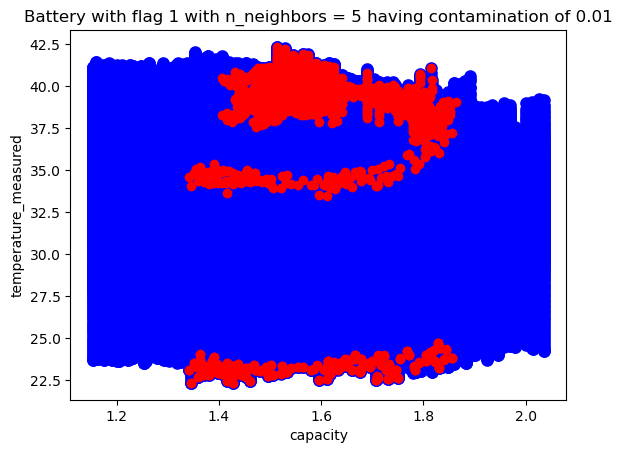

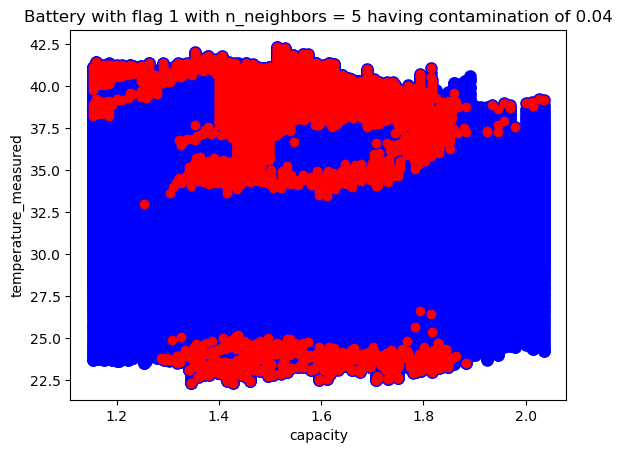

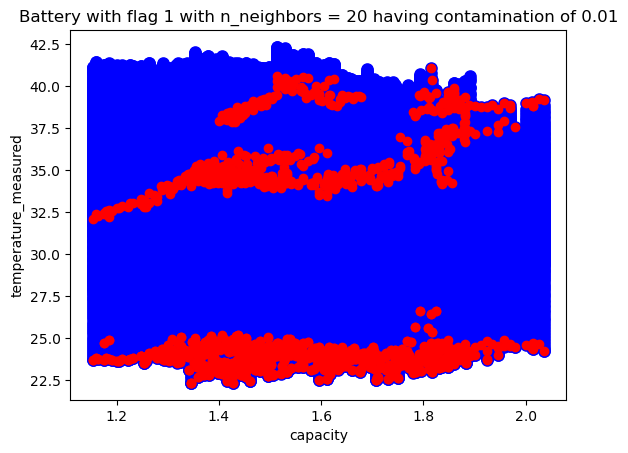

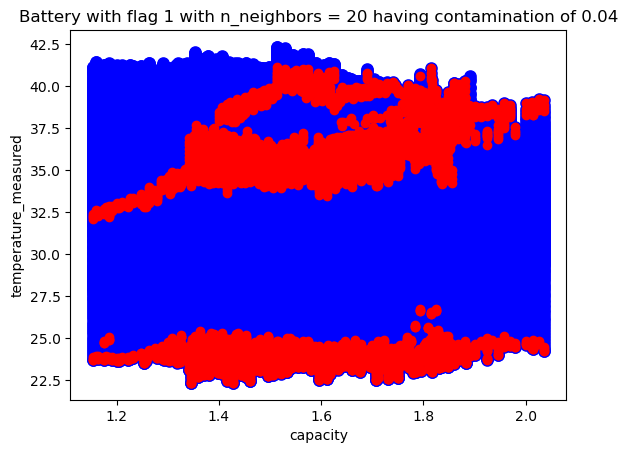

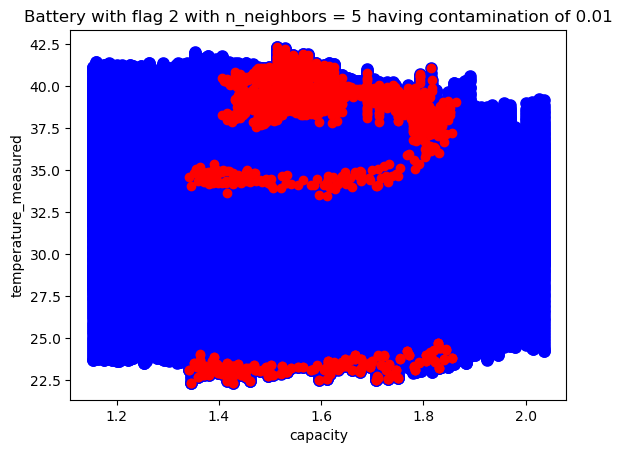

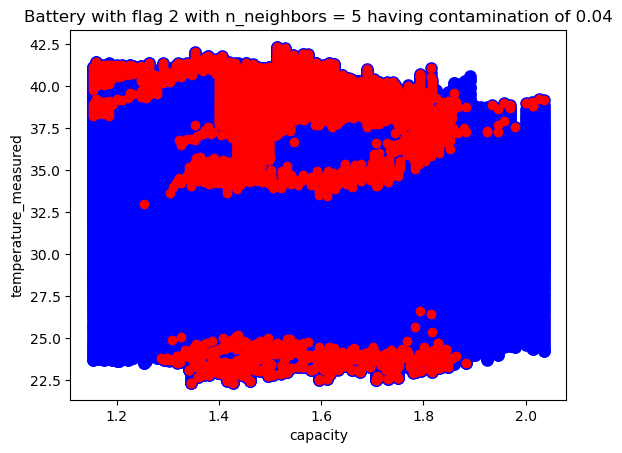

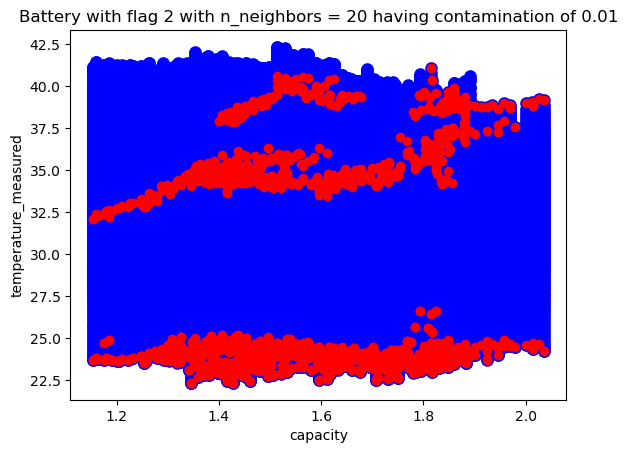

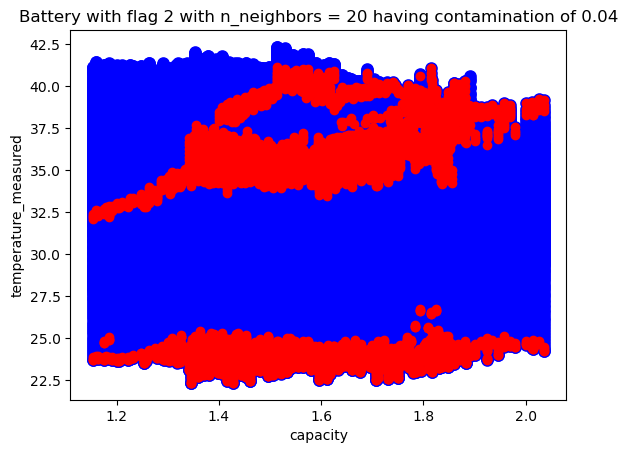

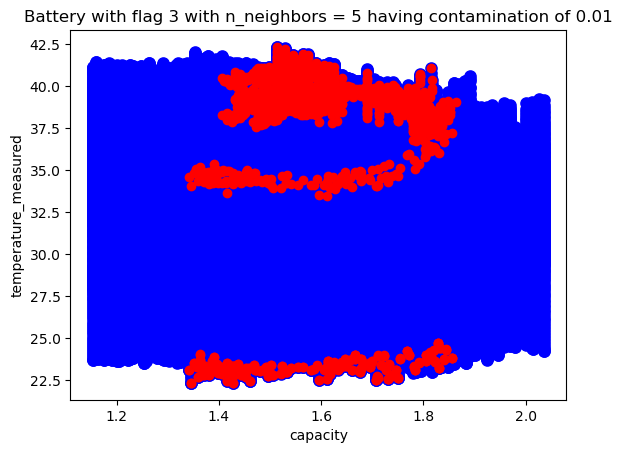

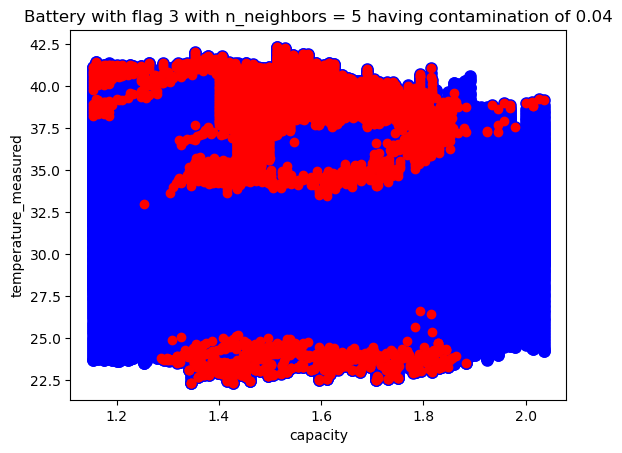

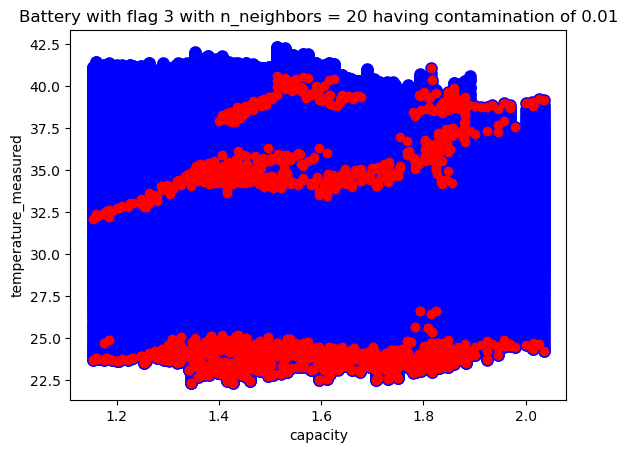

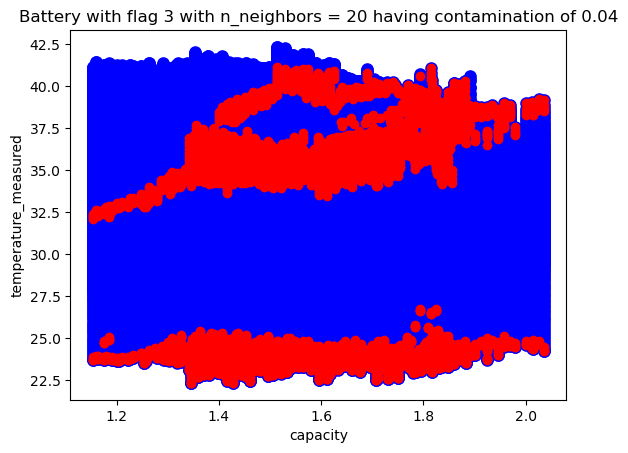

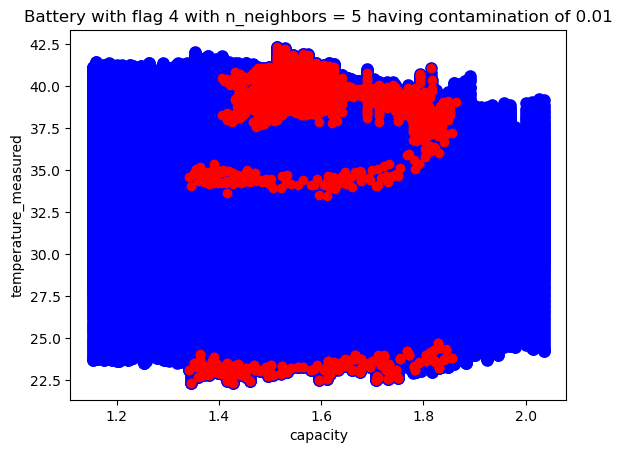

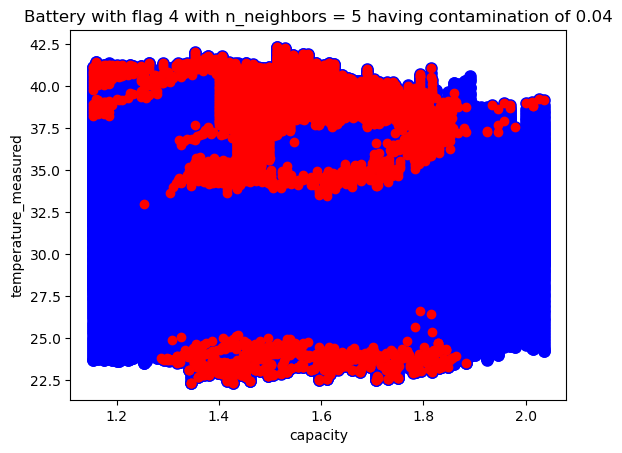

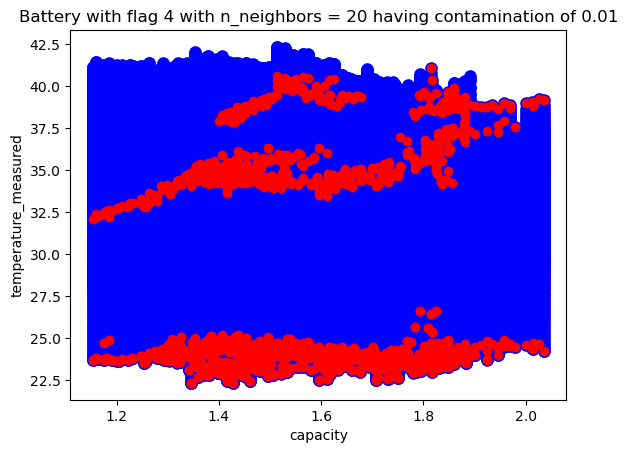

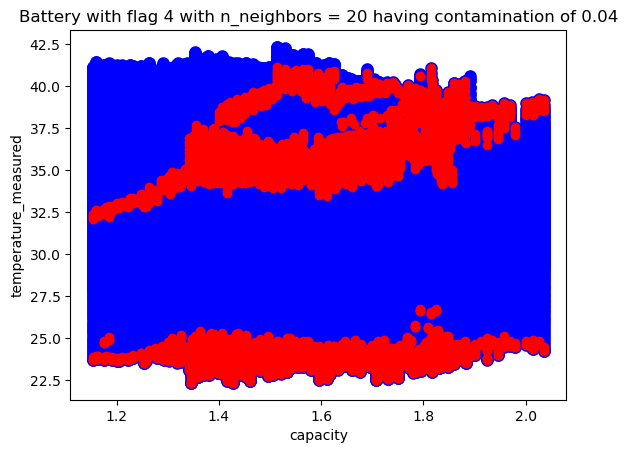

In [104]:
from sklearn.neighbors import LocalOutlierFactor
for f in flags_arr:
    for n in n_neighbors:
        for c in contamination_arr:
            # model specification
            model1 = LocalOutlierFactor(n_neighbors = n, metric = "manhattan", contamination = c)
            # model fitting
            y_pred = model1.fit_predict(fuel_cells_df_copy2)
            # filter outlier index
            outlier_index = np.where(y_pred == -1) # negative values are outliers and positives inliers
            # filter outlier values
            outlier_values = fuel_cells_df_copy2.iloc[outlier_index]
            # plot data
            plt.scatter(fuel_cells_df_copy2["capacity"], fuel_cells_df_copy2["temperature_measured"], color = "b", s = 65)
            # plot outlier values
            plt.scatter(outlier_values["capacity"], outlier_values["temperature_measured"], color = "r") 
            plt.xlabel('capacity')
            plt.ylabel('temperature_measured')
            plt.title('Battery with flag ' + str(f)+ ' with n_neighbors = '+ str(n)+' having contamination of '+str(c))
            plt.show()

- LOF에서 사용되는 하이퍼미터는 n_neighbors = [5, 20] 및 contamination_ = [0.01,0.04]입니다.
- 약 7429개의 데이터 포인트가 최대 최접 이웃(20개)을 사용하고 오염도가 가장 높은 4%를 사용하여 이상값으로 분류되고 있습니다.
- 가장 가까운 이웃이 가장 적고 오염 비율이 가장 낮은 경우, 특히 배터리 용량 중간 범위(1.4~1.6)에서 최소 및 최대 온도가 측정된 이상값의 수가 줄어들고 있습니다. 이 정보는 주제별 전문가에게 알려주어 제거하기 전에 검증할 수 있습니다.


In [105]:
len(y_pred)

185721

In [106]:
fuel_cells_df_copy2

cycle             datetime  capacity  voltage_measured  \
0           1  1207149941000000000  1.856487          4.191492   
1           1  1207149941000000000  1.856487          4.190749   
2           1  1207149941000000000  1.856487          3.974871   
3           1  1207149941000000000  1.856487          3.951717   
4           1  1207149941000000000  1.856487          3.934352   
...       ...                  ...       ...               ...   
185716    132  1219221439000000000  1.341051          3.443760   
185717    132  1219221439000000000  1.341051          3.453271   
185718    132  1219221439000000000  1.341051          3.461963   
185719    132  1219221439000000000  1.341051          3.469907   
185720    132  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  
0          0.000     1  
1         16.781     1  
2         35.703     1  
3         53.781     1  
4         71.922     1  
...          ...   ...  
185716  2686.359     4  
185717  2700.546     4  
185718  2714.640     4  
185719  2728.750     4  
185720  2742.843     4  

[185721 rows x 10 columns]

In [107]:
y_pred_df = pd.DataFrame(data=y_pred,columns=['y_pred'])
fuel_cells_df_copy2_final_lof = pd.concat([fuel_cells_df_copy2,y_pred_df],axis = 1)
fuel_cells_df_copy2_final_lof

cycle             datetime  capacity  voltage_measured  \
0           1  1207149941000000000  1.856487          4.191492   
1           1  1207149941000000000  1.856487          4.190749   
2           1  1207149941000000000  1.856487          3.974871   
3           1  1207149941000000000  1.856487          3.951717   
4           1  1207149941000000000  1.856487          3.934352   
...       ...                  ...       ...               ...   
185716    132  1219221439000000000  1.341051          3.443760   
185717    132  1219221439000000000  1.341051          3.453271   
185718    132  1219221439000000000  1.341051          3.461963   
185719    132  1219221439000000000  1.341051          3.469907   
185720    132  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  y_pred  
0          0.000     1      -1  
1         16.781     1      -1  
2         35.703     1      -1  
3         53.781     1      -1  
4         71.922     1       1  
...          ...   ...     ...  
185716  2686.359     4      -1  
185717  2700.546     4      -1  
185718  2714.640     4      -1  
185719  2728.750     4      -1  
185720  2742.843     4      -1  

[185721 rows x 11 columns]

In [108]:
# No. of outliers when we are considering the highest contamoination i.e 4 %

fuel_cells_df_copy2_final_lof[fuel_cells_df_copy2_final_lof['y_pred'] == -1]

cycle             datetime  capacity  voltage_measured  \
0           1  1207149941000000000  1.856487          4.191492   
1           1  1207149941000000000  1.856487          4.190749   
2           1  1207149941000000000  1.856487          3.974871   
3           1  1207149941000000000  1.856487          3.951717   
193         1  1207149941000000000  1.856487          3.264121   
...       ...                  ...       ...               ...   
185716    132  1219221439000000000  1.341051          3.443760   
185717    132  1219221439000000000  1.341051          3.453271   
185718    132  1219221439000000000  1.341051          3.461963   
185719    132  1219221439000000000  1.341051          3.469907   
185720    132  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
193            -0.001532             35.021738       -0.0006         0.000   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  y_pred  
0          0.000     1      -1  
1         16.781     1      -1  
2         35.703     1      -1  
3         53.781     1      -1  
193     3628.953     1      -1  
...          ...   ...     ...  
185716  2686.359     4      -1  
185717  2700.546     4      -1  
185718  2714.640     4      -1  
185719  2728.750     4      -1  
185720  2742.843     4      -1  

[7429 rows x 11 columns]

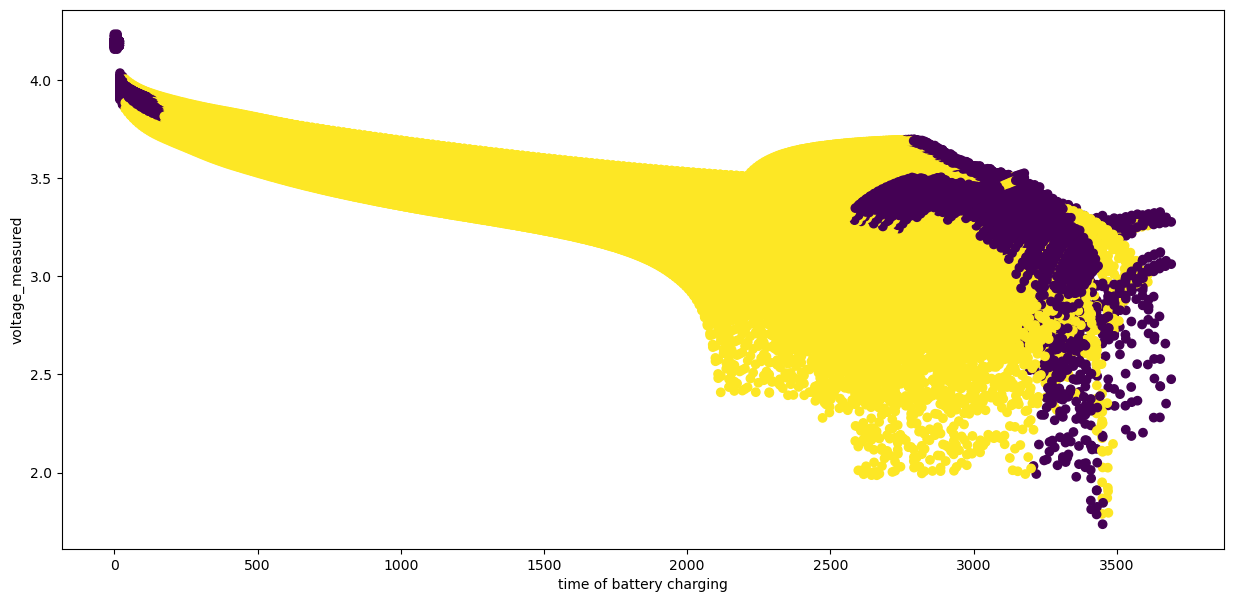

In [109]:
plt.figure(figsize=(15, 7))
plt.scatter(fuel_cells_df_copy2_final_lof['time'], fuel_cells_df_copy2_final_lof['voltage_measured'], c=fuel_cells_df_copy2_final_lof['y_pred'])
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

- 위의 하이퍼파라미터를 사용하여 저차원에서 시각적으로 검증했지만 성능은 격리 포레스트보다 정확도가 떨어지지만 다른 방법보다는 정확도가 높습니다.

## 5. Elliptical Envelope 기반 이상치 탐지

In [110]:
eliptical_df = fuel_cells_df_copy2.copy()

In [111]:
from sklearn.preprocessing import StandardScaler
cols = ['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag']
scaler = StandardScaler()

eliptical_df[cols] = scaler.fit_transform(eliptical_df[cols])
eliptical_df.head()

cycle  datetime  capacity  voltage_measured  current_measured  \
0 -1.791091 -1.424022  1.477315          2.758442          3.255533   
1 -1.791091 -1.424022  1.477315          2.755491          3.261632   
2 -1.791091 -1.424022  1.477315          1.897777         -0.320553   
3 -1.791091 -1.424022  1.477315          1.805782         -0.323138   
4 -1.791091 -1.424022  1.477315          1.736792         -0.318086   

   temperature_measured  current_load  voltage_load      time      flag  
0             -1.998389     -1.194938     -3.149552 -1.705022 -1.281811  
1             -1.999392     -1.194938      2.448187 -1.686519 -1.281811  
2             -1.983728     -2.823146      0.925645 -1.665656 -1.281811  
3             -1.945079     -2.823146      0.883056 -1.645723 -1.281811  
4             -1.898742     -2.823146      0.857769 -1.625721 -1.281811

In [112]:
from sklearn.model_selection import train_test_split

In [113]:
X_train, X_test= train_test_split(eliptical_df, test_size=0.33, random_state=42)

In [114]:
# convert tarin dataframe to arrays
data = X_train[cols].values

In [115]:

from sklearn.covariance import EllipticEnvelope
# instantiate model
model1 = EllipticEnvelope(contamination = 0.1) 
# fit model
model1.fit(data)

EllipticEnvelope()

In [116]:
# convert test dataframe to arrays
# new data for prediction (data needs to be in arrays)
new_data = X_test[cols].values

In [117]:

# predict on new data 
pred1 = model1.predict(new_data)
print(pred1)

[1 1 1 ... 1 1 1]


In [118]:
len(new_data)

61288

In [119]:
len(pred1)

61288

In [120]:
pred_df = pd.DataFrame(data=pred1,columns=['pred1'])
fuel_cells_df_copy2_final_eliptical = pd.concat([X_test,pred_df],axis = 1)


In [121]:
pred_df

pred1
0          1
1          1
2          1
3          1
4          1
...      ...
61283      1
61284      1
61285      1
61286      1
61287      1

[61288 rows x 1 columns]

In [122]:
X_test

cycle  datetime  capacity  voltage_measured  current_measured  \
94986   1.469865  0.026246 -1.686115         -0.469938         -0.319177   
182194  0.703868  2.434538 -0.990579         -3.487875         -0.314516   
96713   1.601178  0.064419 -1.852381          0.757447         -0.314559   
86446   0.857068 -0.156326 -1.028915         -0.553402         -0.320190   
134163  0.681983 -0.221676 -0.240105          0.502181         -0.281645   
...          ...       ...       ...               ...               ...   
170230 -0.412298  2.066050 -0.181811          0.419846         -0.314026   
68294  -0.368526 -0.553487 -0.040528         -0.462780         -0.316967   
184683  0.966496  2.536516 -1.081689         -2.332737         -0.315089   
32289   0.594440 -0.244885 -0.660021          0.863215         -0.322651   
88361   0.988381 -0.121309 -1.278001         -1.101655         -0.317462   

        temperature_measured  current_load  voltage_load      time      flag  
94986              -0.111202      0.434900      0.140418 -0.536915 -0.349901  
182194              1.460708      0.434574     -0.832466  1.052468  1.513919  
96713              -1.444924      0.434737      0.539686 -1.445689 -0.349901  
86446               0.545350      0.434900      0.111138 -0.092657 -0.349901  
134163             -0.370104      0.435715      0.426560 -0.723166  0.582009  
...                      ...           ...           ...       ...       ...  
170230             -0.877855      0.434737      0.438538 -0.639903  1.513919  
68294               0.421779      0.434900      0.144410  0.476073 -0.349901  
184683              1.169705      0.434737     -0.478448  0.957214  1.513919  
32289              -0.574446      0.434248      0.486450 -1.146181 -1.281811  
88361               1.188723      0.434900     -0.075187  0.423009 -0.349901  

[61288 rows x 10 columns]

In [123]:
fuel_cells_df_copy2_final_eliptical[fuel_cells_df_copy2_final_eliptical['pred1'] == -1].shape

(5939, 11)

In [124]:
# predict on all data 
all_data = eliptical_df[cols].values
pred2 = model1.predict(all_data)
print(pred2)

[ 1  1 -1 ... -1 -1 -1]


In [125]:
len(pred2)

185721

In [126]:
len(all_data)

185721

In [127]:
pred_df_all = pd.DataFrame(data=pred2,columns=['pred2'])
final_eliptical = pd.concat([fuel_cells_df_copy2,pred_df_all],axis = 1)
final_eliptical

cycle             datetime  capacity  voltage_measured  \
0           1  1207149941000000000  1.856487          4.191492   
1           1  1207149941000000000  1.856487          4.190749   
2           1  1207149941000000000  1.856487          3.974871   
3           1  1207149941000000000  1.856487          3.951717   
4           1  1207149941000000000  1.856487          3.934352   
...       ...                  ...       ...               ...   
185716    132  1219221439000000000  1.341051          3.443760   
185717    132  1219221439000000000  1.341051          3.453271   
185718    132  1219221439000000000  1.341051          3.461963   
185719    132  1219221439000000000  1.341051          3.469907   
185720    132  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  pred2  
0          0.000     1      1  
1         16.781     1      1  
2         35.703     1     -1  
3         53.781     1     -1  
4         71.922     1     -1  
...          ...   ...    ...  
185716  2686.359     4     -1  
185717  2700.546     4     -1  
185718  2714.640     4     -1  
185719  2728.750     4     -1  
185720  2742.843     4     -1  

[185721 rows x 11 columns]

In [128]:
final_eliptical[final_eliptical['pred2'] == -1]

cycle             datetime  capacity  voltage_measured  \
2           1  1207149941000000000  1.856487          3.974871   
3           1  1207149941000000000  1.856487          3.951717   
4           1  1207149941000000000  1.856487          3.934352   
5           1  1207149941000000000  1.856487          3.920058   
6           1  1207149941000000000  1.856487          3.907904   
...       ...                  ...       ...               ...   
185716    132  1219221439000000000  1.341051          3.443760   
185717    132  1219221439000000000  1.341051          3.453271   
185718    132  1219221439000000000  1.341051          3.461963   
185719    132  1219221439000000000  1.341051          3.469907   
185720    132  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
5              -2.013007             24.909816       -1.9982         2.991   
6              -2.014400             25.105884       -1.9982         2.977   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  pred2  
2         35.703     1     -1  
3         53.781     1     -1  
4         71.922     1     -1  
5         90.094     1     -1  
6        108.281     1     -1  
...          ...   ...    ...  
185716  2686.359     4     -1  
185717  2700.546     4     -1  
185718  2714.640     4     -1  
185719  2728.750     4     -1  
185720  2742.843     4     -1  

[18383 rows x 11 columns]

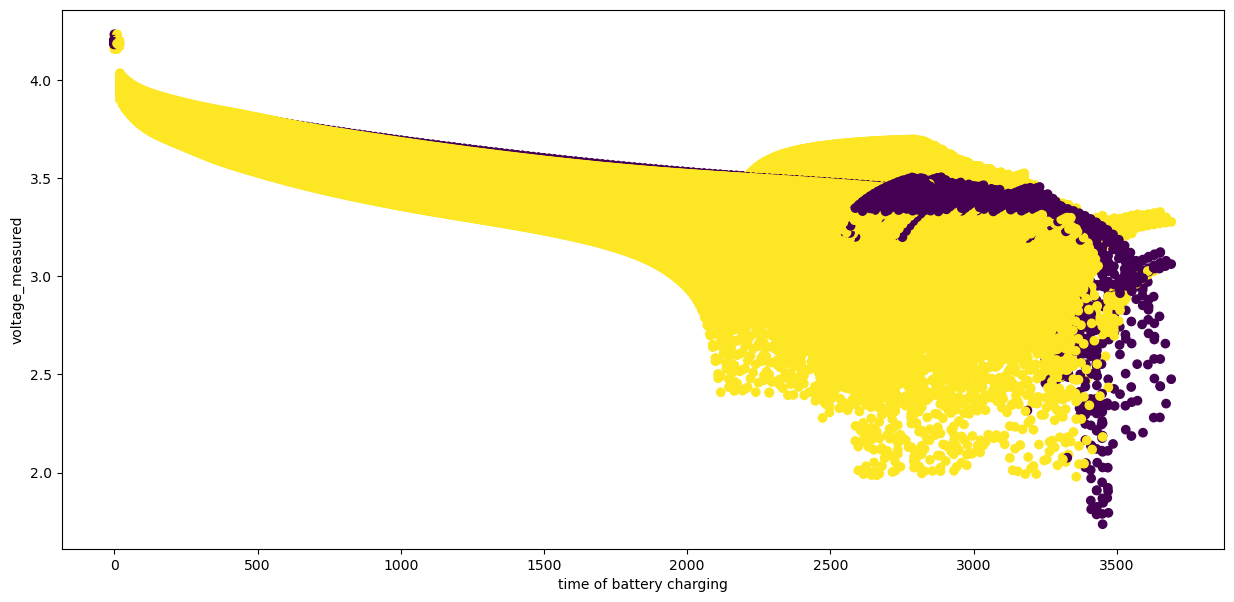

In [129]:
plt.figure(figsize=(15, 7))
plt.scatter(final_eliptical['time'], final_eliptical['voltage_measured'], c=final_eliptical['pred2'])
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

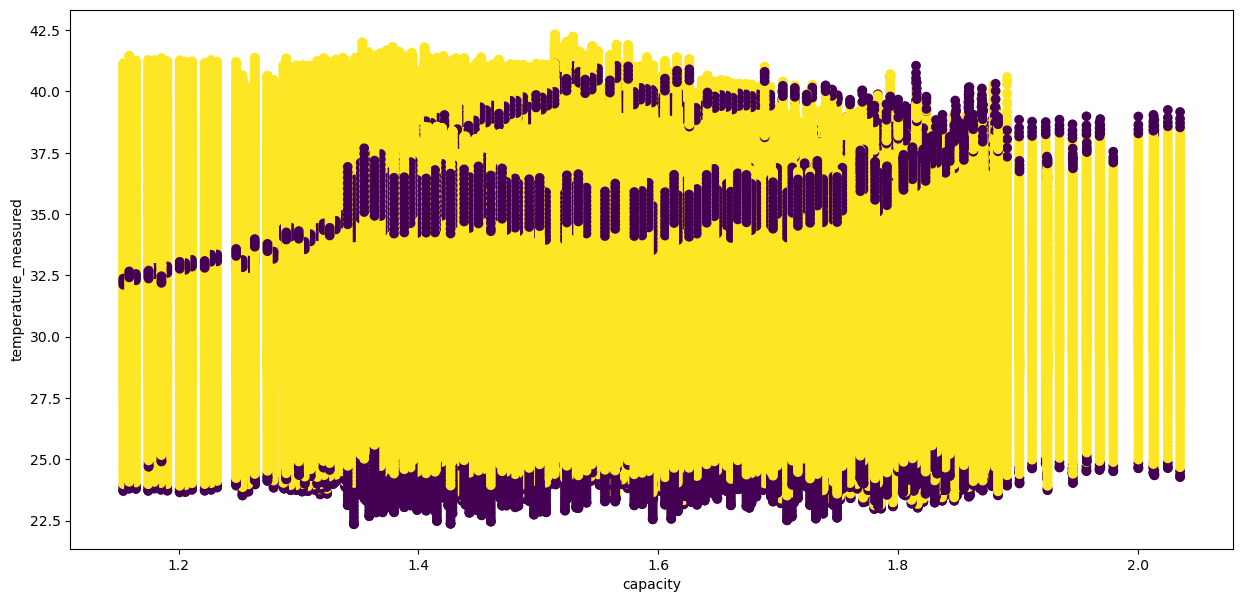

In [130]:
plt.figure(figsize=(15, 7))
plt.scatter(fuel_cells_df_copy2_final_lof['capacity'], fuel_cells_df_copy2_final_lof['temperature_measured'], c=fuel_cells_df_copy2_final_lof['y_pred'])
plt.xlabel('capacity')
plt.ylabel('temperature_measured')
plt.show()

# 위 알고리즘 결과 비교:

#### 5개의 이상치 탐지 수행:
- 1. IQR based
- 2. DBSCAN (density based)
- 3. Isolation Forest
- 4. Local Outlier Factor (LOF)
- 5. Elliptical Envelope


### 1. IQR 기반
- 지금까지 살펴본 바와 같이, 총 **37,766개의 데이터 포인트(데이터의 20.13%)가 IQR 기반 방법을 사용하여 이상값**으로 태그가 지정되었습니다.
- 이 데이터는 방대하고 유용한 정보도 포함할 수 있으므로, 이상값을 처리/탐지할 때는 강력한 이상값 탐지 방법인 SOTA를 사용하는 것이 좋습니다. (최악의 성능)

### 2. DBSCAN (밀도 기반)
- 적절한 히트와 최적의 하이퍼파라미터(eps 및 minpts)를 찾기 위한 실험을 통해 **eps = 0.5, min_samples = 200**을 얻었습니다. 이를 통해 **8009개의 데이터 포인트를 이상값으로 감지할 수 있었습니다**. 위의 하이퍼파라미터를 사용하여 저차원에서 시각적으로 검증했습니다.

### 3. Isolation Forest
- 오염도가 **1%, 2%, 3%, 4%인 이상값은 각각 1858, 3716, 5573, 7431개**입니다.
- 오염도가 가장 적은 경우에도 다양한 기능 집합을 사용하여 저차원에서 시각적으로 검증한 이상값의 정확한 수를 얻을 수 있습니다.
- 그러나 **주제 전문가에 따라 특정 지점이 이상값인지 아닌지 검증**할 수 있지만, 잘 일치하고 있습니다.
- 이상값을 **양호, 평균, 극단적인 이상값으로 쉽게 분류할 수 있습니다.
- 오염도를 계속 높이면 높일수록 극단 이상값으로 분류되는 데이터 포인트의 수가 더 많아집니다.

### 4. Local Outlier Factor (LOF)
- LOF에서 사용되는 하이퍼미터는 n_neighbors = [5, 20] 및 contamination_ = [0.01,0.04]입니다.
- 거의 **7429개의 데이터 포인트가 **최대 가장 가까운 이웃(20개)을 사용하고 오염률이 4%로 가장 높은 **이상값**으로 분류되고 있습니다.
- 위의 하이퍼파라미터를 사용하여 저차원에서 시각적으로 검증했지만, 성능은 격리 포레스트보다는 정확도가 떨어지지만 다른 방법보다는 정확도가 높습니다.
- 가장 가까운 이웃이 가장 적고 오염 비율이 가장 낮기 때문에 특히 배터리 용량 중간 범위(1.4~1.6)에서 최소 및 최대 온도가 측정되는 이상값의 수가 적습니다. 이 정보는 주제별 전문가에게 알려주어 제거하기 전에 검증할 수 있습니다.
- 극단적인 엔드포인트와 함께, 온도 대 용량의 이변량 분석에서 오염도가 최대 4%까지 증가하면 중간 수준의 이상값도 이상값으로 간주됩니다.

### 5. Elliptical Envelope
- 오염도를 하이퍼파라미터로 제공하면 (-1) 레이블이 지정된 **18387개의 데이터 포인트, 즉 이상값을 얻을 수 있습니다.**
- 극단적인 끝점과 함께, 온도 대 용량에 대한 이변량 분석에서 오염도가 1%로 낮은 경우에도 중간 수준의 이상값은 이상값으로 간주됩니다.

### 최종 성능 결론:
#### Isolation Forest >>  Local Outlier Factor (LOF) >  DBSCAN (밀도 기반) >  Elliptical Envelope >> IQR based

# 결론 및 인사이트 도출:

- 배터리 사용 횟수가 증가함에 따라 배터리 용량이 감소합니다. 또한 **시간이 지나면 용량이 감소**합니다.
- 배터리 B0006(2)은 새 배터리일 때 용량이 가장 큽니다. 반면 B0018과 B0007은 사용하지 않을 때 용량이 가장 적습니다.
- 시간이 지남에 따라 **B0006은 다른 배터리보다 훨씬 더 열화되는 경향**을 보이는 반면 **B0007은 가장 효율적인 용량**을 가지고 있습니다. 또한, **플래그 2가 있는 배터리(B0006)는 최대 이상값 수가** 있습니다. 이것이 배터리 2의 성능이 최악인 주된 이유일 수 있습니다. **분류된 아나몰로스의 데이터 포인트는 중소기업에서 필요한 **조사**를 거친 후 경영진에게 강조 표시되어야 하며, 이를 통해 팀은 주어진 기능의 값에 대해 **적절한 개선 조치를 취할 수 있습니다**.
- 주기 전반에 걸쳐 배터리 충전에 대한 지속적인 테스트가 없었습니다. 처음 세 개의 배터리(5,6,7)는 동시에 충전/테스트된 반면, 네 번째 배터리(B0018)는 2008년 7월 이후에 충전/테스트되었으며 그 사이에 몇 번의 휴식 시간을 가졌습니다. 
- 시간이 지남에 따라 배터리 충전 주기가 감소하는 일반적인 추세는 거의 동일합니다.
- 최근에 출시된 **배터리(B0018)는 시간이 지남에 따라 평균 용량을 유지하고 있음을 분명히 알 수 있습니다.
- 배터리 B0002의 용량은 시간이 지남에 따라 가장 많이 저하되는 반면, 파란색의 경우 일정 기간 동안 용량 측면에서 가장 효율적입니다.
- 배터리 충전 시간이 증가함에 따라 네 개의 배터리 모두 평균적으로 용량도 증가하고 있습니다.
- 배터리의 경우 충전 시간이 증가함에 따라 감가상각이 증가**하는데, 이는 충전할 때마다 측정된 온도_가 증가하기 때문입니다.
- 용량이 훨씬 높은 배터리와 용량이 훨씬 낮지만 최소 온도가 측정된** 배터리가 가장 많은 이상값을 보이고 있습니다. 이러한 이상값은 해당 분야 전문가와 함께 확인한 후 **NASA 팀에서 이 동작의 정확한 근본 원인을 찾기 위해 노력할 수 있습니다**.
- 평균적으로 **온도가 가장 적게 측정된 배터리는 이상값이 더 많습니다**.
- 최소 충전 시간으로 **최대 전압을 생성하는 배터리 데이터 포인트는 이상값/아나몰리에 해당합니다**.
- 또한, 오염이 가장 적은 상태에서 충전하는 데 최대 시간이 필요한 배터리 데이터 포인트는 세라틴 이상치/아나몰리에 해당합니다.
- 이상값의 오염도를 4%로 높이면 1%의 오염도와 비교하여 시각적으로 보이는 아나몰리를 이상값으로 분류할 수 있습니다.
- 또한 최대 오염도가 4%인 경우, **충전하는 데 최대 시간이 필요하고 전압이 낮은 배터리 데이터 포인트는 세라틴 이상값/아나몰리에 해당합니다.
- 계속해서 **오염 %를 증가시키면 **극단 이상값으로 분류되는 데이터 포인트의 수가 더 많아집니다**.
- 가장 가까운 이웃이 가장 적고 오염률이 가장 낮을수록, 특히 최소 및 최대 온도가 측정된 **중간 배터리 용량 범위(1.4-1.6)에서 이상값의 수가 줄어들고 있습니다**. 이 정보는 주제별 전문가에게 알려주어 제거하기 전에 검증할 수 있습니다.
